# Technical notebook - Exploratory Data Analysis

### Sources:
https://financetrain.com/measure-model-performance-in-r-using-rocr-package/

https://github.com/AristotelisPap/Lending-Club-Loan-Charge-off-Prediction-using-Neural-Networks-and-Deep-Learning-Explanation-models/blob/master/Anchors_Lending_Loan.ipynb


https://github.com/yanxiali/Predicting-Default-Clients-of-Lending-Club-Loans/blob/master/LC_Loan_full.ipynb

https://books.google.com/books?id=6AuLDwAAQBAJ&pg=PA51&lpg=PA51&dq=sns+subplots&source=bl&ots=gUYvb9Z4ti&sig=ACfU3U08xrWK-KQudCP7Kjl-v1KcO8sLQQ&hl=en&sa=X&ved=2ahUKEwjVrcHu2vLnAhUigXIEHd4iDOM4KBDoATAFegQICxAB#v=onepage&q=X_val&f=false

https://www.edureka.co/blog/tensorflow-tutorial/

## Table of contents:
    1. Introduction
    2. Data
    3. Target variable
    4. Featuer selection I.: EDA
        4.1. Understanding the columns
        4.2. Drop columns: irrelevant, redundant or poor format
        4.3. Drop columns: payment, collection and other future info
        4.4. Drop columns: too much missing values
        

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

pd.set_option('display.max_colwidth', -1)

## 1. Introduction

The objective of this project is to **make an accurate and interpretable prediction** on the loan payment outcomes (whether a loan will be fully paid or charged off) using LendingClub personal loan dataset. As a result the model can help investors to make a better investment decision.

This problem is a binary classification since we have only two classes to predict.

## 2. Data

For this project we will use **LendingClub personal loans of the year 2014**. The dataset can be downloaded from LendingClub website: https://www.lendingclub.com/info/download-data.action

Data includes yearly consumer loans given out with information was available at the time of the application and payment information, alltogether 150 features. A short description of the columns was also provided as a Data Dictionary.

In [ ]:
#import data from zip file
from zipfile import ZipFile
zip_file = ZipFile('data/LoanStats3c_securev1.csv.zip')
data = pd.read_csv(zip_file.open('LoanStats3c_securev1.csv'), low_memory=False, header=1)

#reading excel file which contains the column descriptions
description = pd.read_excel('data/LCDataDictionary.xlsx')

In [ ]:
data.info()

In [ ]:
data.sample(3)

In [ ]:
data.loan_amnt.isna().sum() #there are rows without loan amount

In [ ]:
#removed two rows with full NAN values
data = data[data.loan_amnt.notnull()]
data.shape

### 2.1 Create test dataset

We will retain a test set based on the issued day (issue_d), the first 9 months are for training, the last 3 month will be assigned for test.

In [ ]:
data.issue_d.head(3)

In [ ]:
data['issue_d'] = pd.to_datetime(data['issue_d'], format='%b-%Y')

In [ ]:
data['issue_d'].value_counts(normalize=True).sort_index()

I decided to keep loans issued in November and December to keep for test purposes. These loans make up roughly 15% of the total dataset.

In [ ]:
test = data.loc[data['issue_d'].dt.month >= 11].reset_index(drop=True)
data = data.loc[data['issue_d'].dt.month < 11].reset_index(drop=True)

print('Test dataset:',test.shape)
print('Train dataset:', data.shape)

## 3. Target variable

We will predict if the loan was fully paid or defaulted. This information is availabale in the **loan_status** column. Meaning of the loan_status categories, detailed description can be found at
[https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-)
   * **Fully paid**: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.
   * **Current**: Loan is up to date on all outstanding payments. 
   * **In Grace Period**: Loan is past due but within the 15-day grace period. 
   * **Late (16-30)**: Loan has not been current for 16 to 30 days. 
   * **Late (31-120)**: Loan has not been current for 31 to 120 days. 
   * **Default**: Loan has not been current for an extended period of time.
   * **Charged Off**: Loan for which there is no longer a reasonable expectation of further payments. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance.

We can see the distribution of loan_status: 

In [ ]:
data['loan_status'].value_counts()

We decided to ignore the "gray" categories, where we do not know yet the final outcome of the repayment, so we will keep the loans which were "Fully Paid" or "Charged Off", and convert their value to 0 and 1 respectively into a target variable. 

In [ ]:
data = data.loc[(data.loan_status=='Fully Paid') | (data.loan_status=='Charged Off')]
data.loc[data['loan_status']=='Fully Paid', 'target'] = 0
data.loc[data['loan_status']=='Charged Off', 'target'] = 1

In [ ]:
data.loan_status.value_counts(normalize=True, dropna=True)

The dataset looks very unbalanced, which is necessary to handle during training our model and applying metrics.

In [ ]:
sns.set(style='white')
fig1 = plt.figure(figsize=(4,5))
ax = sns.countplot(x ='loan_status', data=data, palette=["#8c8c8c", "#e54632"], 
                   order=['Fully Paid', 'Charged Off'])
for p in ax.patches:
    ax.annotate('{:,}'.format(p.get_height()), (p.get_x()+0.26, p.get_height()-15000), 
                color='white', fontsize=13, fontweight='bold')

plt.title('Target categories\n', fontsize=16)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel('')
ax.set_ylabel('')
for pos in ['right', 'top', 'left']:
    ax.spines[pos].set_visible(False)
plt.yticks([]);
fig1.savefig('img/Target_var');

## 4. Feature selection and feature engineering

The dataset has originally 150 columns/features, but not all of them can be used for predictions. 
Features will be dropped due to the following reasons:
  * They contain irrelevant or redundant information
  * They contain information that are not available at the time of credit application
  * Features which require too much data processing
  * They have too many missing values (more than 50% of the data)
  * Highly correlated with each other

Further feature processing:
  * Convert types of the features
  * Log transformation
  * Handling outliers 

### 4.1 Understanding the columns

Using the detailed description of the "Data Dictionary", two examples from the dataset, dtype and missing value information I created file which helped me to make a proper decision which columns to keep. Decision is stored in a separate, col_selection_2014.xlsx file.

In [ ]:
from preprocessing.loan_helper import column_description
desc = column_description(data, description) 
# desc.to_excel('preprocessing/col_desc_2014.xlsx') #Only for the first run of the notebook
col_selection = pd.read_excel('preprocessing/col_selection_2014.xlsx', index_col=0)

print('Table created from Data Dictionary:')
display(desc.head(2))
print('\nTable created after feature inspection:')
display(col_selection.head(2))

In [ ]:
print('The summary of reasons to drop columns:')
print(col_selection.Drop_reason.value_counts(), '\n')
# selected_col = col_selection.loc[col_selection.Decision == 'keep', 'col_name'].to_list()
# print('The number of selected columns:', len(selected_col))

### 4.2. Drop columns: irrelevant, redundant or poor format

### Irrelevant

In [ ]:
drop_list1 = col_selection.loc[col_selection.Drop_reason=='irrelevant', 'col_name'].tolist()
drop_list1

Let's see why these are irrelevant:

In [ ]:
data.policy_code.value_counts()

In [ ]:
data.application_type.value_counts()

As we can see, there are no joint applications, and we have found only one policy code.

### Redundant

In [ ]:
drop_list2 = col_selection.loc[col_selection.Drop_reason=='redundant', 'col_name'].tolist()
drop_list2

In [ ]:
print((data.fico_range_high - data.fico_range_low).value_counts())

The difference between high and low fico scores are fix.

### Poor format

In [ ]:
drop_list3 = col_selection.loc[col_selection.Drop_reason=='poor_format', 'col_name'].tolist()
print(drop_list3)

In [ ]:
def col_info(data, col_name):
    return print(f'{col_name}: {data[col_name].nunique():,} different {data[col_name].dtype} type entries.')
[col_info(data, col) for col in drop_list3]

In [2]:
data.drop(columns=drop_list1+drop_list2+drop_list3, inplace=True)
data.shape

NameError: name 'data' is not defined

### 4.3 Drop columns: payment, collection and other future info

Becaues our objective is to support an investment decision, we can take into consideration information which are available at the time of our decision. That is why any payment, collection and other future info can not be taken into consideration. 

### Payment info

In [ ]:
drop_list4 = col_selection.loc[col_selection.Drop_reason=='payment_info', 'col_name'].tolist()
print(drop_list4)

### Collection

In [ ]:
drop_list5 = col_selection.loc[col_selection.Drop_reason=='collection', 'col_name'].tolist()
print(drop_list5)

### Future info

In [ ]:
drop_list6 = col_selection.loc[col_selection.Drop_reason=='future_info', 'col_name'].tolist()
print(drop_list6)

In [ ]:
data.drop(columns=drop_list4+drop_list5+drop_list6, inplace=True)
data.shape

### 4.4 Drop columns: too much missing values

In [ ]:
missing_cols = []
for col in data.columns.tolist():
    count = data[col].isna().sum()
    row = {}
    row['Column name'] = col
    row['Missing Values'] = count
    row['Missing of total%'] = round(data[col].isna().sum()/data.shape[0]*100, 1)
    if count:
        missing_cols.append(row)
missing_df = pd.DataFrame(missing_cols).sort_values('Missing Values', ascending=False)
print(f'There are {missing_df.shape[0]} columns with missing values.')
display(missing_df)

I choose the 50% as a treshold to drop columns with missing values.

In [ ]:
drop_list7 = missing_df.loc[missing_df["Missing of total%"]>50, 'Column name'].tolist()
print(drop_list7)

In [ ]:
data.drop(columns=drop_list7, inplace=True)
data.shape

### 4.6. Inspecting the remaining features

After reducing the initial 150 feauters to 63, now I will inspect the features one by one, which includs the following tasks:
    - Data type transformation for a more suitable format
    - Visualization of distribution: bar plot for categorical and KDE plot for continuous variabls
    - Transformation of features (e.g., log transformation)

In [ ]:
def make_plot(col, col_name=None, continuous=True):
    '''
    ------------------------------------------
    Inputs: 
    -------
    col: column (string)
    col_name: column full name (string)
    continuous: the type of the feature (bool)
    ------------------------------------------
    Output:
    -------
    plots
    '''
    sns.set_style('white')
    
    if col_name == None:
        col_name = col
    color_1 = '#de4343'
    color_2 = '#999999'
    
    w = 9 if not continuous and data[col].nunique()<=5 else 15 #figure width
    
    fig1, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(w,3))
    #=========================================================================================
    #plot top left hand: distribution
    #=========================================================================================
    if continuous:  
        sns.distplot(data[col], kde=False, color=color_1, hist_kws={'alpha':.7}, ax=ax1)
    else:
        sns.countplot(data[col], order=sorted(data[col].unique()), ax=ax1, 
                      color=color_1, alpha=.85, saturation=1) # 
    ax1.set_xlabel('')
    ax1.set_ylabel('Count')
    ax1.set_title(col_name)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    #=========================================================================================
    # plot top right hand: horizontal boxplot grouped by loan_status
    #=========================================================================================
    if continuous:
        sns.boxplot(x=col, y='loan_status', data=data, order=['Charged Off', 'Fully Paid'], 
                    palette=[color_1, color_2], ax=ax2, saturation=1, boxprops={'alpha':.85}) 
        ax2.set_title(col_name + ' by Loan Status')
        ax2.spines['left'].set_visible(False)
    else:
        defaulted = (data.groupby(col)['loan_status']
                     .value_counts(normalize=True, dropna=False)[:,'Charged Off']
                     .sort_index())
        sns.barplot(x=defaulted.index, y=defaulted.values, ax=ax2, 
                    color=color_1, alpha=.85, saturation=1) 
        ax2.set_title("Proportion of Charged Off Loans in each category")
        ax2.set_ylim([0,defaulted.values.max()+0.05])
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    fig1.tight_layout()
    
    fig2 = plt.figure(constrained_layout=True, figsize=(w,3))
    gs = fig2.add_gridspec(1, 3)
    fig2_ax1 = fig2.add_subplot(gs[0, :-1])
    fig2_ax2 = fig2.add_subplot(gs[0, -1])
    #=========================================================================================
    # plot bottom left hand: kde plot of the variable for Fully Paid and for Charged Off loans
    #=========================================================================================
    if continuous:
        data_1 = data.loc[data['loan_status']=='Fully Paid', col]
        data_2 = data.loc[data['loan_status']=='Charged Off', col]
        sns.kdeplot(data_1, shade=True, label='Fully Paid', color=color_2, ax=fig2_ax1)
        sns.kdeplot(data_2, shade=True, label='Charged Off', color=color_1, ax=fig2_ax1)
    else:
        sns.countplot(x=col, hue='loan_status', data=data, order=sorted(data[col].unique()),
                      ax=fig2_ax1, hue_order=['Fully Paid', 'Charged Off'],
                      saturation=1, alpha=.85, palette=[color_2, color_1]) 
        fig2_ax1.set_xlabel('')
        fig2_ax1.set_ylabel('Count')
    fig2_ax1.spines['top'].set_visible(False)
    fig2_ax1.spines['right'].set_visible(False)
    fig2_ax1.legend(frameon=False)
    #=========================================================================================
    #plot bottom right hand: quantile-quantile plot
    #=========================================================================================
    if continuous:
        sm.qqplot(data[col], line='q', ax=fig2_ax2, mec=None, ms=1)
        fig2_ax2.spines['top'].set_visible(False)
        fig2_ax2.spines['right'].set_visible(False)
        fig2_ax2.set_facecolor('#ededed')
    else:
        fig2_ax2.set_visible(False)
    fig2.tight_layout()

In [ ]:
def print_desc(col):
    '''Prints out the meaning of the column from the Data Dictionary.'''
    print(desc.loc[desc.col_name==col, 'Description'].values[0])

### loan_amnt

In [ ]:
print_desc('loan_amnt')

In [ ]:
data.loan_amnt.describe()

In [ ]:
make_plot('loan_amnt', 'Loan amount')

### term

In [ ]:
print_desc('term')

In [ ]:
data.term.value_counts(normalize=True)

In [ ]:
data['term'] = data['term'].apply(lambda s: int(s.split()[0])).astype(int)

In [ ]:
make_plot('term', "Term", continuous=False)

### int_rate

In [ ]:
print_desc('int_rate')

In [ ]:
data.int_rate.head(3)

In [ ]:
data.int_rate = data.int_rate.apply(lambda x: x[:-1]).astype(float)

In [ ]:
data.int_rate.describe()

In [ ]:
make_plot('int_rate', 'Interest Rate')

As the value of the interest rate is the result of a preliminary credit assessment, we will disregard it as a feature for prediction. It will be useful to make comparison of investments before and after our classification.

### installment

In [ ]:
print_desc('installment')

In [ ]:
data.installment.describe()

In [ ]:
make_plot('installment', 'Installment')

### grade

In [ ]:
print_desc('grade')

In [ ]:
data.grade.value_counts(normalize=True).sort_index()

In [ ]:
make_plot('grade', 'Grade', continuous=False)

### emp_length

In [ ]:
print_desc('emp_length')

In [ ]:
data.emp_length.value_counts(dropna=False).sort_index()

First, the values should be converted into a numerical variable:

In [ ]:
emp_lens = {'10+ years': 10, '9 years': 9, '4 years': 4, '2 years': 2, '< 1 year': 0,
            '1 year': 1, '6 years': 6, '5 years': 5, '8 years': 8, '7 years': 7, '3 years':3}
data['emp_length'] = data.emp_length.apply(lambda x: emp_lens.get(x,np.nan))

In [ ]:
data.emp_length.value_counts(dropna=False, normalize=True).sort_index()

In [ ]:
make_plot('emp_length', continuous=False)

### home_ownership

In [ ]:
print_desc('home_ownership')

In [3]:
print(data.home_ownership.value_counts())

NameError: name 'data' is not defined

Let's convert the 'ANY' category into 'OTHER'

In [ ]:
data['home_ownership'] = data.home_ownership.apply(lambda x: 'OTHER' if x=='ANY' else x)
print(data.home_ownership.value_counts())

In [ ]:
make_plot('home_ownership', 'Home ownership', continuous=False)

### annual_inc

In [ ]:
print_desc('annual_inc')

In [ ]:
data['annual_inc'].describe()

In [ ]:
data.annual_inc.max()

Annual income ranges between \\$3K and \$7.5Million with a median of \\$65K. 

In case of annual income we can see extreme high values, which compared to the maximum amount of loan (\$40,000) might be very suspicious, and we can assume here a typo. This information is self-reported, so it might happen. Since it can spoil our model, I decided to convert the values above a certain limit to lower values.

### annual_inc: handling outliers

**Find outliers using IQR (inter quartile) method**

In [68]:
median = np.quantile(data.annual_inc, 0.5)
Q1 = np.quantile(data.annual_inc, 0.25)
Q3 = np.quantile(data.annual_inc, 0.75)
upper_tres1 = median + 1.5 * (Q3 - Q1)
print(f'Upper treshold: ${upper_tres1:,.0f}.')
print(f'There are {len(data[data.annual_inc > upper_tres1]):,} loans with income above this treshold.')

Upper treshold: $131,000.
There are 15,839 loans with income above this treshold.


**Find outliers using standard deviation method**

In [69]:
avg = data.annual_inc.mean()
std = np.std(data.annual_inc)
upper_tres2 = avg + 3 * std
print(f'Upper treshold: ${upper_tres2:,.0f}.')
print(f'There are {len(data[data.annual_inc >= upper_tres2]):,} loans with income above this treshold.')

Upper treshold: $243,252.
There are 2,191 loans with income above this treshold.


**Find outliers using 99 quantile**

In [70]:
upper_tres3 = np.quantile(data.annual_inc, 0.99)
print(f'Upper treshold: ${upper_tres3:,.0f}.')
print(f'There are {len(data[data.annual_inc >=upper_tres3]):,} loans with income above this treshold.')

Upper treshold: $250,000.
There are 2,102 loans with income above this treshold.


The results of the last two methods are very close to each other. I decided to use \\$250,000 as a treshold for determine the outliers. Values above this treshold will be converted below the treshold.

In [71]:
def convert_income(value):
    if value <= 250000:
        return value
    elif value <= 2500000:
        return value/10
    else:
        return value/100

In [72]:
data['annual_inc'] = data['annual_inc'].apply(lambda x: convert_income(x))

In [73]:
data['annual_inc'].describe()

count    200024.000000
mean     71913.812642 
std      37531.624388 
min      3000.000000  
25%      45000.000000 
50%      64000.000000 
75%      90000.000000 
max      250000.000000
Name: annual_inc, dtype: float64

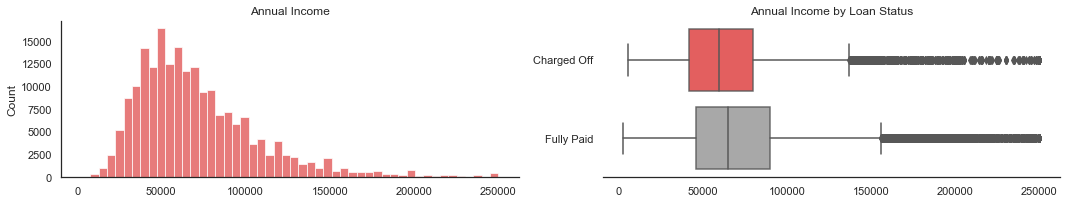

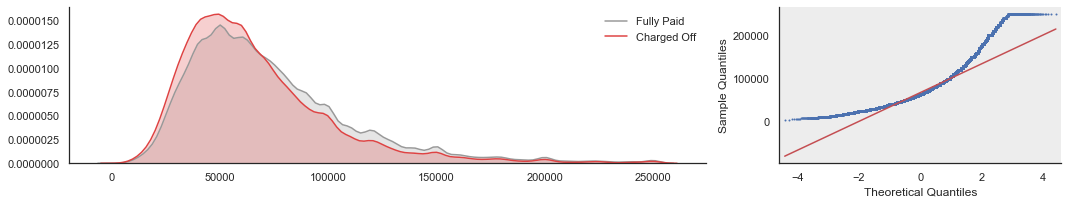

In [74]:
make_plot('annual_inc', 'Annual Income')

### annual_inc: log transformation

In [75]:
data['annual_inc_log'] = data['annual_inc'].apply(lambda x:np.log10(x+1))

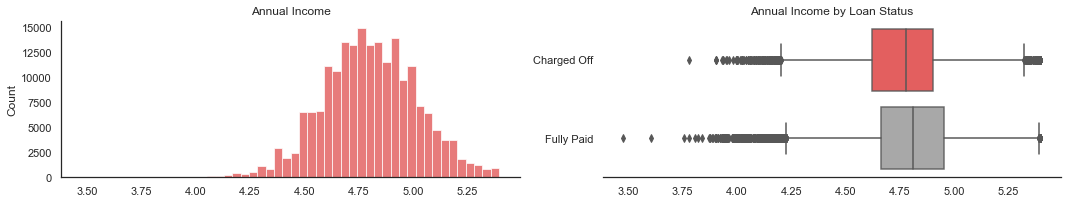

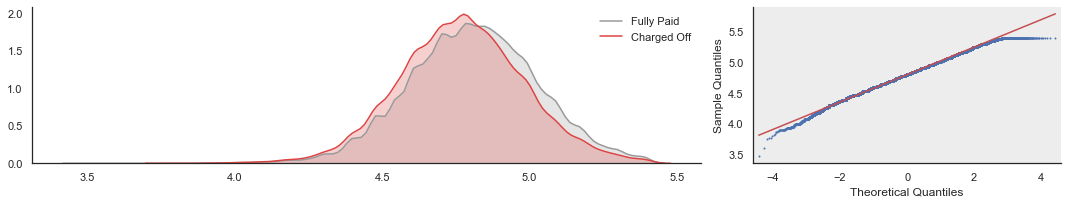

In [76]:
make_plot('annual_inc_log', 'Annual Income')

In [77]:
data.drop(columns='annual_inc', inplace=True)

### verification_status

In [78]:
print_desc('verification_status')

Indicates if income was verified by LC, not verified, or if the income source was verified


In [79]:
data.verification_status.value_counts(dropna=False, normalize=True)

Source Verified    0.420695
Not Verified       0.293490
Verified           0.285816
Name: verification_status, dtype: float64

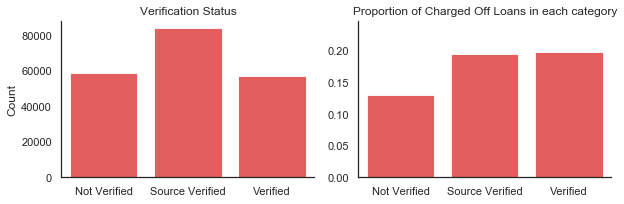

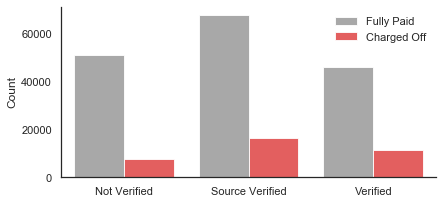

In [80]:
make_plot('verification_status', 'Verification Status', continuous=False)

### purpose

In [81]:
print_desc('purpose')

A category provided by the borrower for the loan request. 


In [114]:
data['purpose'].value_counts(dropna=False)

debt_consolidation    121231
credit_card           47443 
home_improvement      11221 
other                 8542  
major_purchase        3241  
medical               1972  
small_business        1942  
car                   1561  
moving                1133  
vacation              1000  
house                 629   
renewable_energy      101   
wedding               8     
Name: purpose, dtype: int64

In case of wedding purpose there was no chargedd off loans. In case of other purpuses the following chart shows the risk.

In [139]:
def plot_default_rate(col, col_name, rotation=0, sort_values=True):
    '''Rotation refers to the x categori labels view.'''
    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(15,3))
    defaulted = data.groupby(col)['target'].mean()
    if sort_values:
        defaulted = data.groupby(col)['target'].mean().sort_values()
    ax = sns.barplot(x=defaulted.index, y=defaulted.values, color = '#de4343', alpha=0.85)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(f'Proportion of defaulted loans by {col_name}')
    plt.ylabel('')
    plt.xlabel('')
    ax.set_xticklabels(defaulted.index.tolist(), rotation=rotation)
    plt.ylim([0,defaulted.values.max()+0.05]);

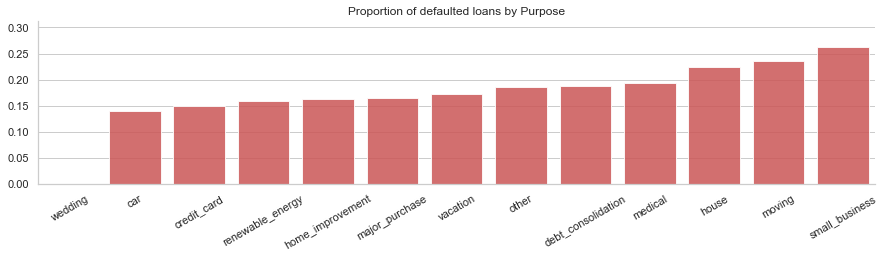

In [140]:
plot_default_rate('purpose', 'Purpose', 30)

We can see big differencies regarding the defaulted rate in different categories.

### addr_state

In [115]:
print_desc('addr_state')

The state provided by the borrower in the loan application


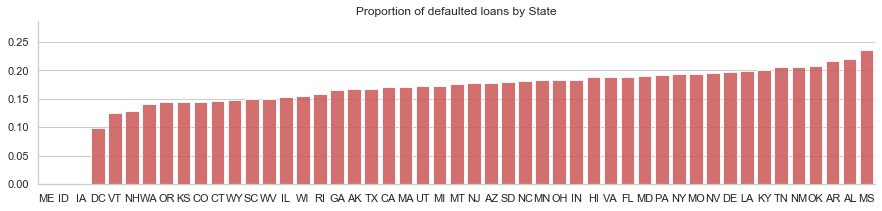

In [141]:
plot_default_rate('addr_state', 'State')

### dti

In [116]:
print_desc('dti')

A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.


In [117]:
data['dti'].describe()

count    200024.000000
mean     17.931677    
std      7.917055     
min      0.000000     
25%      12.000000    
50%      17.560000    
75%      23.620000    
max      39.990000    
Name: dti, dtype: float64

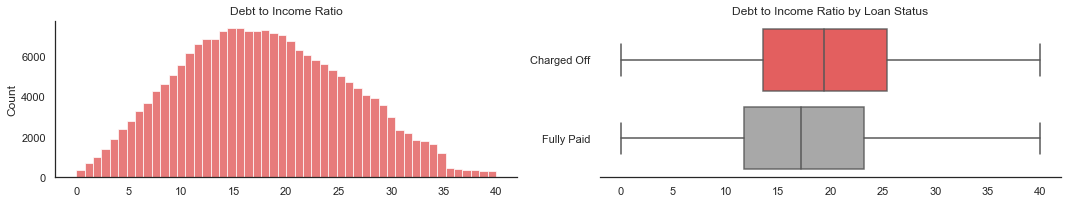

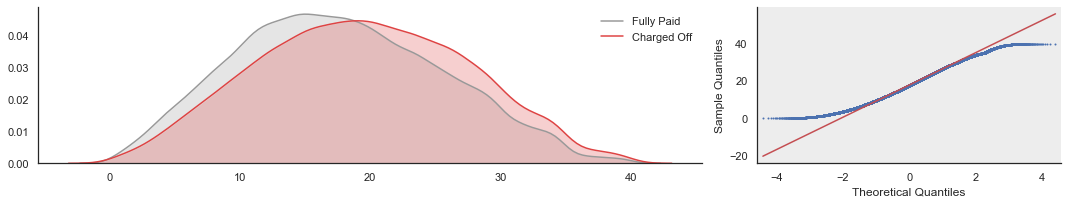

In [118]:
make_plot('dti', 'Debt to Income Ratio')

In [97]:
data.groupby('loan_status')['dti'].mean()

loan_status
Charged Off    19.443609
Fully Paid     17.606759
Name: dti, dtype: float64

### delinq_2yrs

In [219]:
print_desc('delinq_2yrs')

The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years


In [98]:
data['delinq_2yrs'].describe()

count    200024.000000
mean     0.344349     
std      0.897857     
min      0.000000     
25%      0.000000     
50%      0.000000     
75%      0.000000     
max      22.000000    
Name: delinq_2yrs, dtype: float64

In [124]:
data['delinq_2yrs'].value_counts(normalize=True)[:5]

0.0    0.792840
1.0    0.134939
2.0    0.041930
3.0    0.015423
4.0    0.006804
5.0    0.003635
Name: delinq_2yrs, dtype: float64

80% of entries are 0.

In [137]:
defaulted = (data.groupby('delinq_2yrs')['target'].mean())
defaulted.index

Float64Index([ 0.0,  1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0,
              11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 21.0,
              22.0],
             dtype='float64', name='delinq_2yrs')

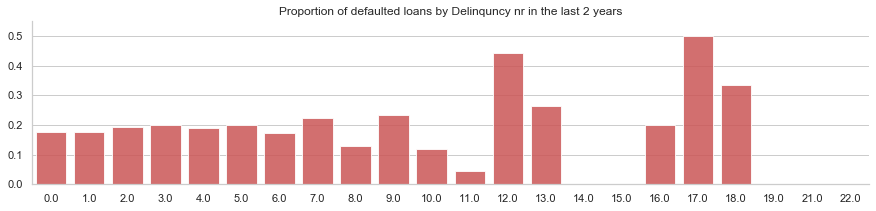

In [142]:
plot_default_rate('delinq_2yrs', 'Delinquncy nr in the last 2 years', sort_values=False)

There might be some connection between this variable and risk, but it is ambigues, because above some higher values the defaulted ratio seems to drop. 

I will collect the zero inflated features into a list for further investigations:

In [165]:
zero_inflated_cols = ['delinq_2yrs']

### earliest_cr_line

In [143]:
print_desc('earliest_cr_line')

The month the borrower's earliest reported credit line was opened


In [144]:
data['earliest_cr_line'].head(3)

0    Nov-2000
1    Oct-1999
2    Apr-1997
Name: earliest_cr_line, dtype: object

I will convert to numeric value with a meaning of: months since earliest credit line.

In [145]:
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], format='%b-%Y')

In [146]:
data['earliest_cr_line'].head(3)

0   2000-11-01
1   1999-10-01
2   1997-04-01
Name: earliest_cr_line, dtype: datetime64[ns]

In [147]:
data['earliest_cr_line'] = data['issue_d'] - data['earliest_cr_line']
data['earliest_cr_line'] = data['earliest_cr_line'].apply(lambda x: pd.Timedelta(x)).dt.days
data['earliest_cr_line'] = data['earliest_cr_line'] / 365 * 12
data['earliest_cr_line'] = data['earliest_cr_line'].apply(np.floor).astype(int)

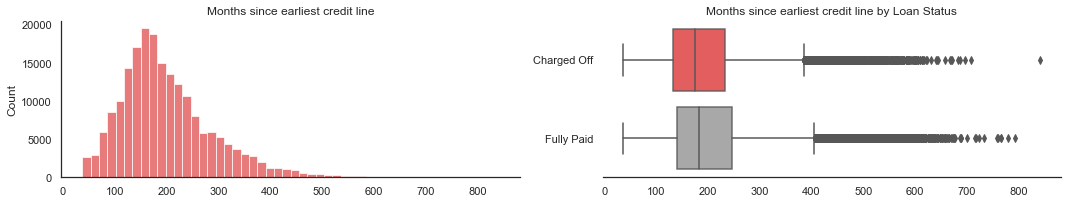

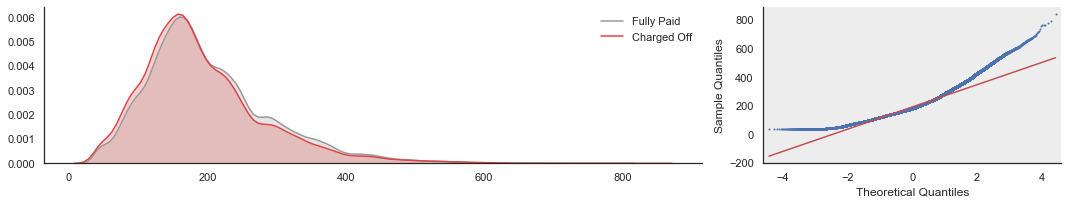

In [148]:
make_plot('earliest_cr_line', 'Months since earliest credit line')

In [151]:
data.drop(columns=['issue_d'], inplace=True)

### fico_range_high

In [152]:
print_desc('fico_range_high')

The upper boundary range the borrower’s FICO at loan origination belongs to.


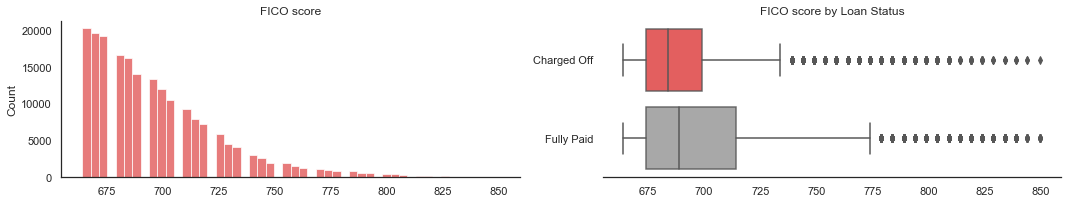

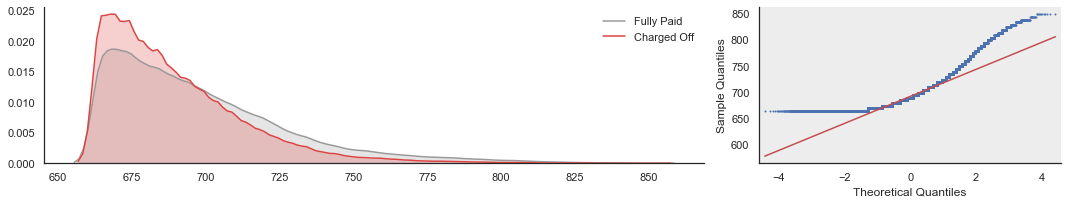

In [213]:
make_plot('fico_range_high', 'FICO score')

### inq_last_6mths

In [154]:
print_desc('inq_last_6mths')

The number of inquiries in past 6 months (excluding auto and mortgage inquiries)


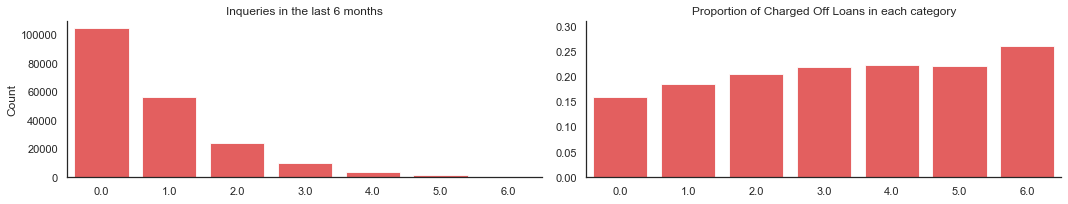

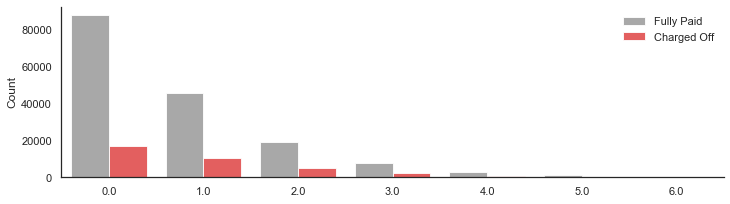

In [155]:
make_plot('inq_last_6mths', 'Inqueries in the last 6 months', continuous=False)

We can see slight increase in deliquency with the increase of the number of inqueries

### pub_rec

In [156]:
print_desc('pub_rec')

Number of derogatory public records


In [157]:
data['pub_rec'].value_counts(normalize=True)[:3]

0.0    0.821286
1.0    0.150657
2.0    0.018723
3.0    0.005659
Name: pub_rec, dtype: float64

We can see, that in 82% the number of public records is zero, in 15% it is one, and only in roughly 3% it exceeds one.

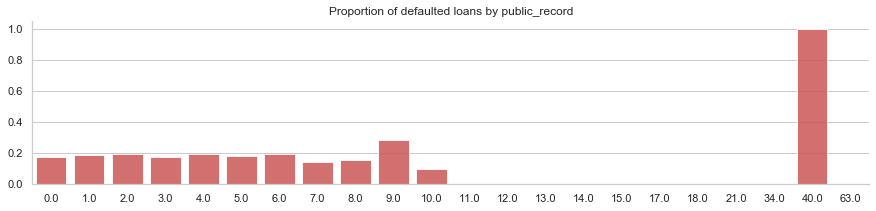

In [158]:
plot_default_rate('pub_rec', 'public_record', sort_values=False)

In [274]:
data.loc[data['pub_rec']==1, 'loan_status'].value_counts(normalize=True)

Fully Paid     0.810088
Charged Off    0.189912
Name: loan_status, dtype: float64

In [188]:
data.groupby('loan_status')['pub_rec'].mean()

loan_status
Charged Off    0.240263
Fully Paid     0.221201
Name: pub_rec, dtype: float64

In [160]:
data['pub_rec'].value_counts()[10:]

10.0    10
11.0    4 
13.0    2 
21.0    1 
40.0    1 
14.0    1 
12.0    1 
34.0    1 
18.0    1 
15.0    1 
17.0    1 
63.0    1 
Name: pub_rec, dtype: int64

There are only very few observations with high number of public records.

In [166]:
zero_inflated_cols.append('pub_rec')

### pub_rec_bankruptcies

In [191]:
print_desc('pub_rec_bankruptcies')

Number of public record bankruptcies


In [192]:
data['pub_rec_bankruptcies'].value_counts(normalize=True)[:3]

0.0    0.871555
1.0    0.121460
2.0    0.005424
3.0    0.001185
Name: pub_rec_bankruptcies, dtype: float64

In [193]:
data.groupby('loan_status')['pub_rec_bankruptcies'].mean()

loan_status
Charged Off    0.148889
Fully Paid     0.135148
Name: pub_rec_bankruptcies, dtype: float64

In [194]:
zero_inflated_cols.append('pub_rec_bankruptcies')

### revol_util

In [173]:
print_desc('revol_util')

Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.


In [174]:
data['revol_util'].head(3)

0    68.7%
1    30.8%
2    42.3%
Name: revol_util, dtype: object

In [175]:
data['revol_util'] = data['revol_util'].str.strip('%').astype(float)/100

In [176]:
data['revol_util'].head(3)

0    0.687
1    0.308
2    0.423
Name: revol_util, dtype: float64

In [177]:
data['revol_util'].describe()

count    199919.000000
mean     0.557605     
std      0.230223     
min      0.000000     
25%      0.391000     
50%      0.564000     
75%      0.733000     
max      8.923000     
Name: revol_util, dtype: float64

We can see here extreme values, 8 times higher utilization than the limit.

In [179]:
data['revol_util_cap'] = data['revol_util'].apply(lambda x: 2 if x>2 else x) #only for vizualization purpose

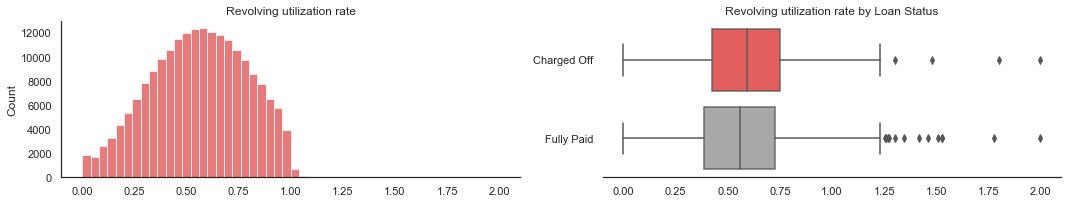

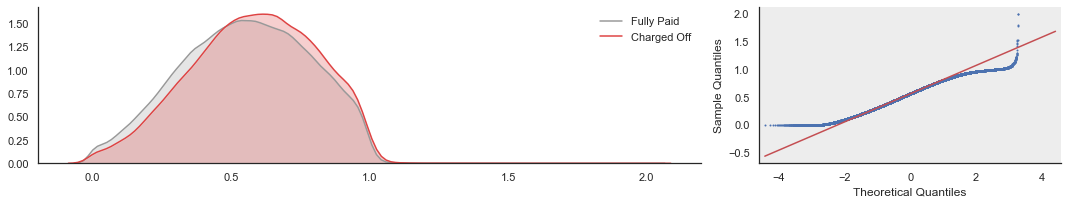

In [180]:
make_plot('revol_util_cap', 'Revolving utilization rate')

In [227]:
data.drop(columns='revol_util_cap', inplace=True)

In [189]:
data.groupby('loan_status')['revol_util'].mean()

loan_status
Charged Off    0.581592
Fully Paid     0.552450
Name: revol_util, dtype: float64

### collections_12_mths_ex_med

In [195]:
print_desc('collections_12_mths_ex_med')

Number of collections in 12 months excluding medical collections


In [209]:
data['collections_12_mths_ex_med'].value_counts(normalize=True)

0.0     0.986157
1.0     0.012958
2.0     0.000780
3.0     0.000075
4.0     0.000015
5.0     0.000005
16.0    0.000005
20.0    0.000005
Name: collections_12_mths_ex_med, dtype: float64

In [199]:
data.groupby('loan_status')['collections_12_mths_ex_med'].mean()

loan_status
Charged Off    0.016703
Fully Paid     0.014644
Name: collections_12_mths_ex_med, dtype: float64

In [200]:
data[data['collections_12_mths_ex_med']==0].target.mean()

0.17656333172796634

In [208]:
data[data['collections_12_mths_ex_med']!=0].target.mean()

0.20007222824124232

This variable can be used as a dummy variable.

In [210]:
zero_inflated_cols.append('collections_12_mths_ex_med')

### tot_coll_amt

In [211]:
print_desc('tot_coll_amt')

Total collection amounts ever owed


In [224]:
data['tot_coll_amt'].value_counts(normalize=True).iloc[:6]

0.0      0.847963
50.0     0.002230
100.0    0.001760
75.0     0.001445
200.0    0.000940
60.0     0.000915
Name: tot_coll_amt, dtype: float64

The 84% of the entries is zero.

In [225]:
data['tot_coll_amt'].value_counts().iloc[:10]

0.0      169613
50.0     446   
100.0    352   
75.0     289   
200.0    188   
60.0     183   
150.0    167   
55.0     158   
70.0     154   
90.0     146   
Name: tot_coll_amt, dtype: int64

In [228]:
data.groupby('loan_status')['tot_coll_amt'].mean()

loan_status
Charged Off    242.598186
Fully Paid     280.895057
Name: tot_coll_amt, dtype: float64

In [229]:
zero_inflated_cols.append('tot_coll_amt')

### chargeoff_within_12_mths

In [230]:
print_desc('chargeoff_within_12_mths')

Number of charge-offs within 12 months


In [231]:
data['chargeoff_within_12_mths'].value_counts(normalize=True).iloc[:5]

0.0    0.990441
1.0    0.008449
2.0    0.000975
3.0    0.000095
4.0    0.000025
Name: chargeoff_within_12_mths, dtype: float64

In [233]:
data[data['chargeoff_within_12_mths']>0].target.mean()

0.1647489539748954

In [234]:
zero_inflated_cols.append('chargeoff_within_12_mths')

### delinq_amnt

In [285]:
print_desc('delinq_amnt')

The past-due amount owed for the accounts on which the borrower is now delinquent.


In [239]:
data['delinq_amnt'].value_counts(normalize=True).iloc[:5]

0.0     0.996490
30.0    0.000070
75.0    0.000055
50.0    0.000040
25.0    0.000035
Name: delinq_amnt, dtype: float64

In [238]:
data[data['delinq_amnt']>0].target.mean()

0.16809116809116809

In [ ]:
zero_inflated_cols.append('delinq_amnt')

### pct_tl_nvr_dlq

In [286]:
print_desc('pct_tl_nvr_dlq')

Percent of trades never delinquent


### tax_liens

In [288]:
print_desc('tax_liens')

Number of tax liens


In [111]:
print(data.columns.tolist())

['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_

In [ ]:
mo_sin_cols = ['mths_since_last_delinq','mo_sin_old_il_acct','mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 
               'mo_sin_rcnt_tl',  'mths_since_recent_bc', 'mths_since_recent_inq']

In [260]:
num_acc_cols = ['open_acc', 'total_acc', 'acc_now_delinq', 'acc_open_past_24mths', 'mort_acc',
                'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 
                'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 
                'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 
                'num_tl_90g_dpd_24m', 'num_tl_op_past_12m']

In [262]:
balance_cols = ['revol_bal','tot_cur_bal','total_rev_hi_lim','avg_cur_bal','bc_open_to_buy', 
                'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit']

In [261]:
pct_cols = ['revol_util','bc_util', 'percent_bc_gt_75']

### 4.6 Inspect the features with vizualization

## 6. Exploring numeric features

In [52]:
print('The number of qualitative features: ', end='')
print(len(dataset.select_dtypes(['object']).columns))
print('The number of quantitative features (including target): ', end='')

print(len(dataset.select_dtypes(['float64', 'int64']).columns))

The number of qualitative features: 4
The number of quantitative features (including target): 56


### 6.1. Continuous variables

In [53]:
continuous_vars = ['loan_amnt', 'installment', 'annual_inc', 'dti', 'revol_bal', 'revol_util', 'tot_coll_amt',
                   'tot_cur_bal', 'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                   'delinq_amnt', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bal_ex_mort',
                   'total_bc_limit', 'total_il_high_credit_limit', 'pct_tl_nvr_dlq']
print(f'There are {len(continuous_vars)} continuous variables.')

There are 19 continuous variables.


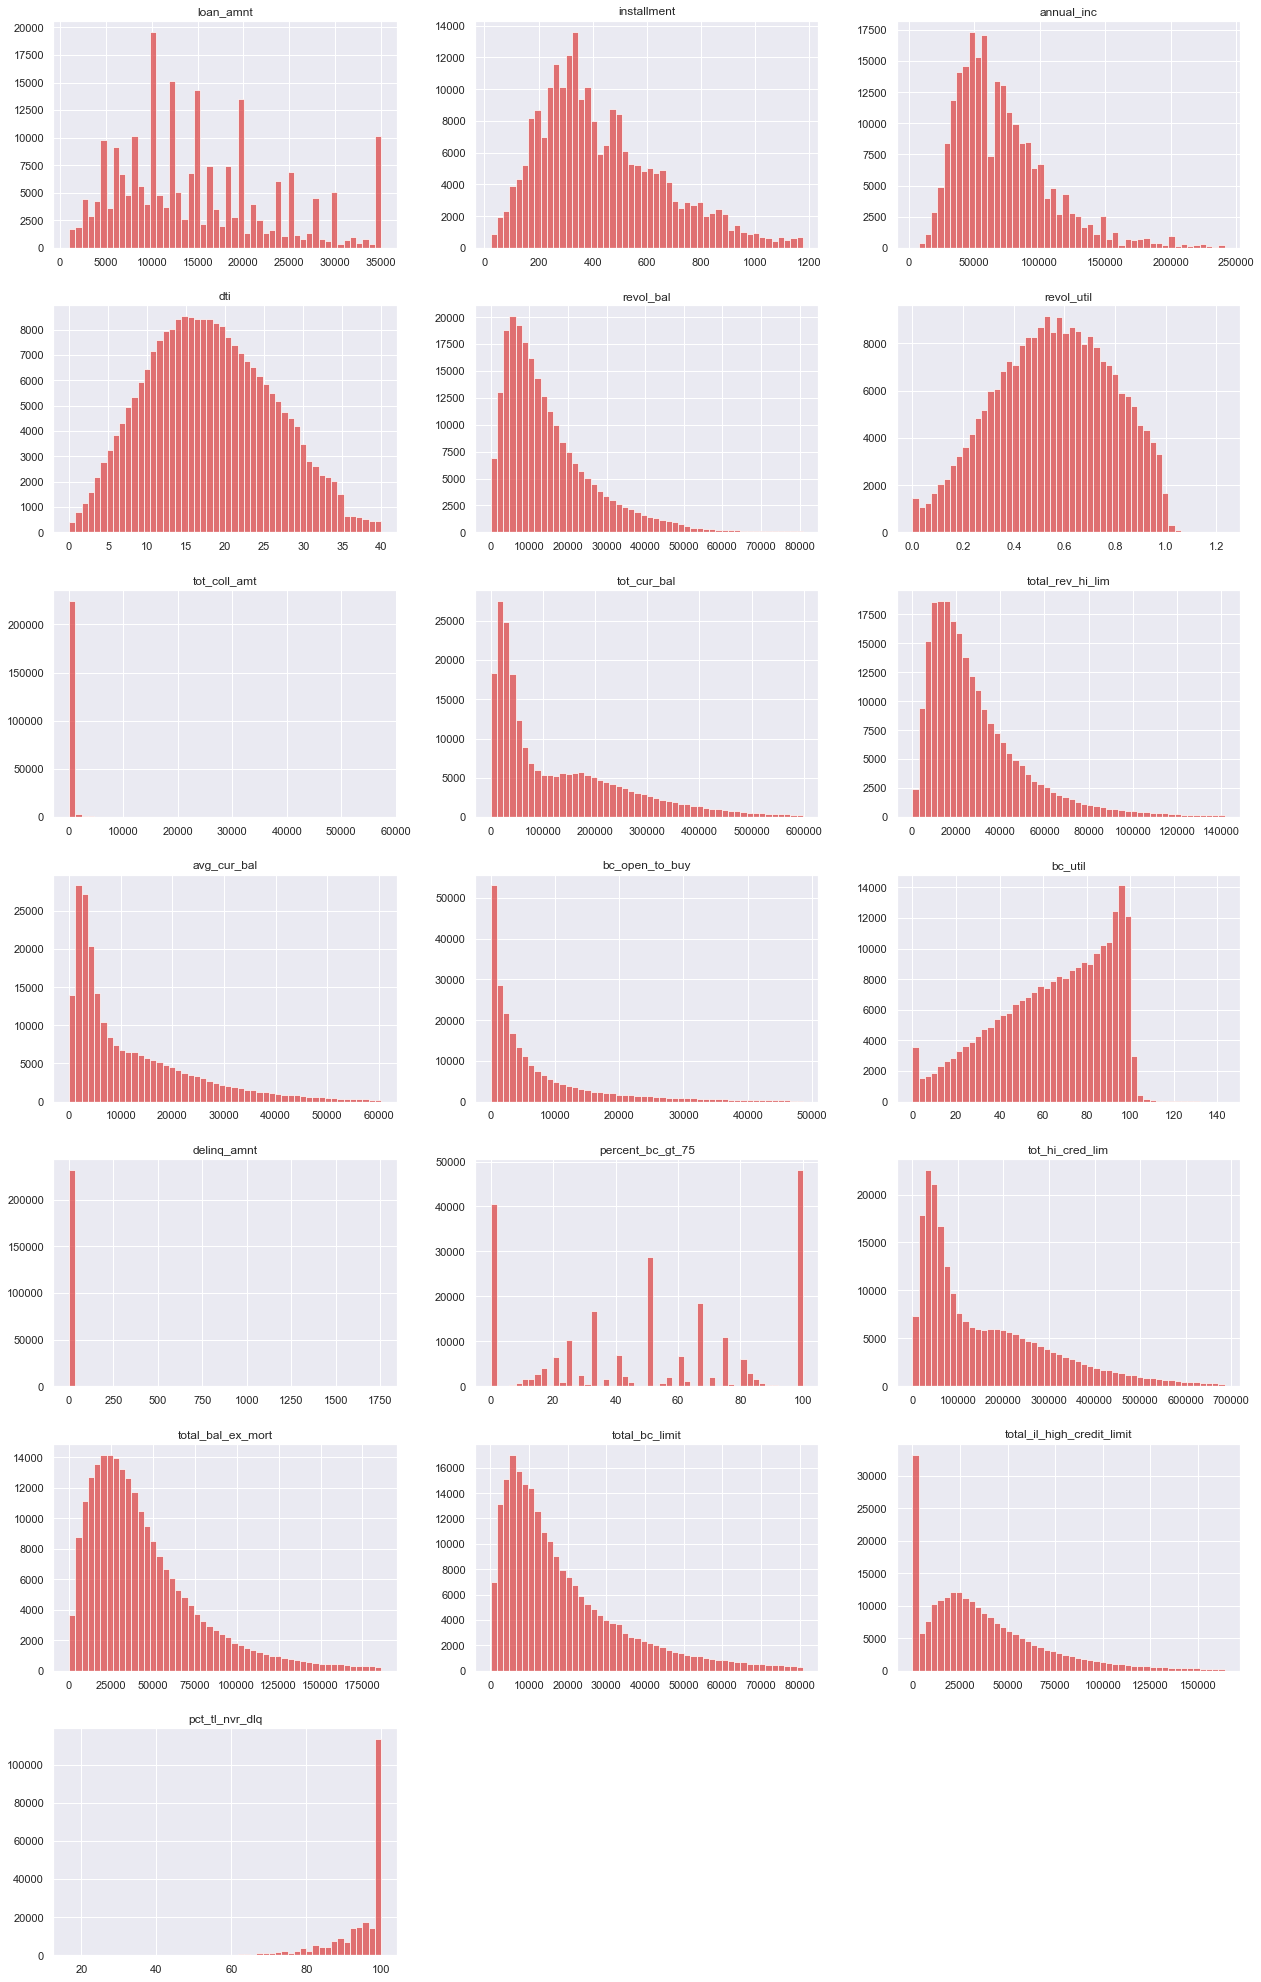

In [54]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(7,3, figsize=(18,28))

for i, feat in enumerate(continuous_vars, start=1): 
    ax = plt.subplot(7,3,i)
    #handle outliers:
    upper_treshold = dataset[feat].mean() + 3 * np.std(dataset[feat])
    data = dataset.loc[dataset[feat]<upper_treshold, feat].copy() #values w/o outliers
    sns.distplot(data, kde=False, axlabel=False, hist_kws={'color':'#db3b3b', 'alpha':0.7})
    ax.set_title(feat)
plt.subplot(7,3,20).set_visible(False)
plt.subplot(7,3,21).set_visible(False)
fig.tight_layout(pad=2.0)
fig.savefig('img/Hist_cont_feats.png');

**Normality test with QQ plot**

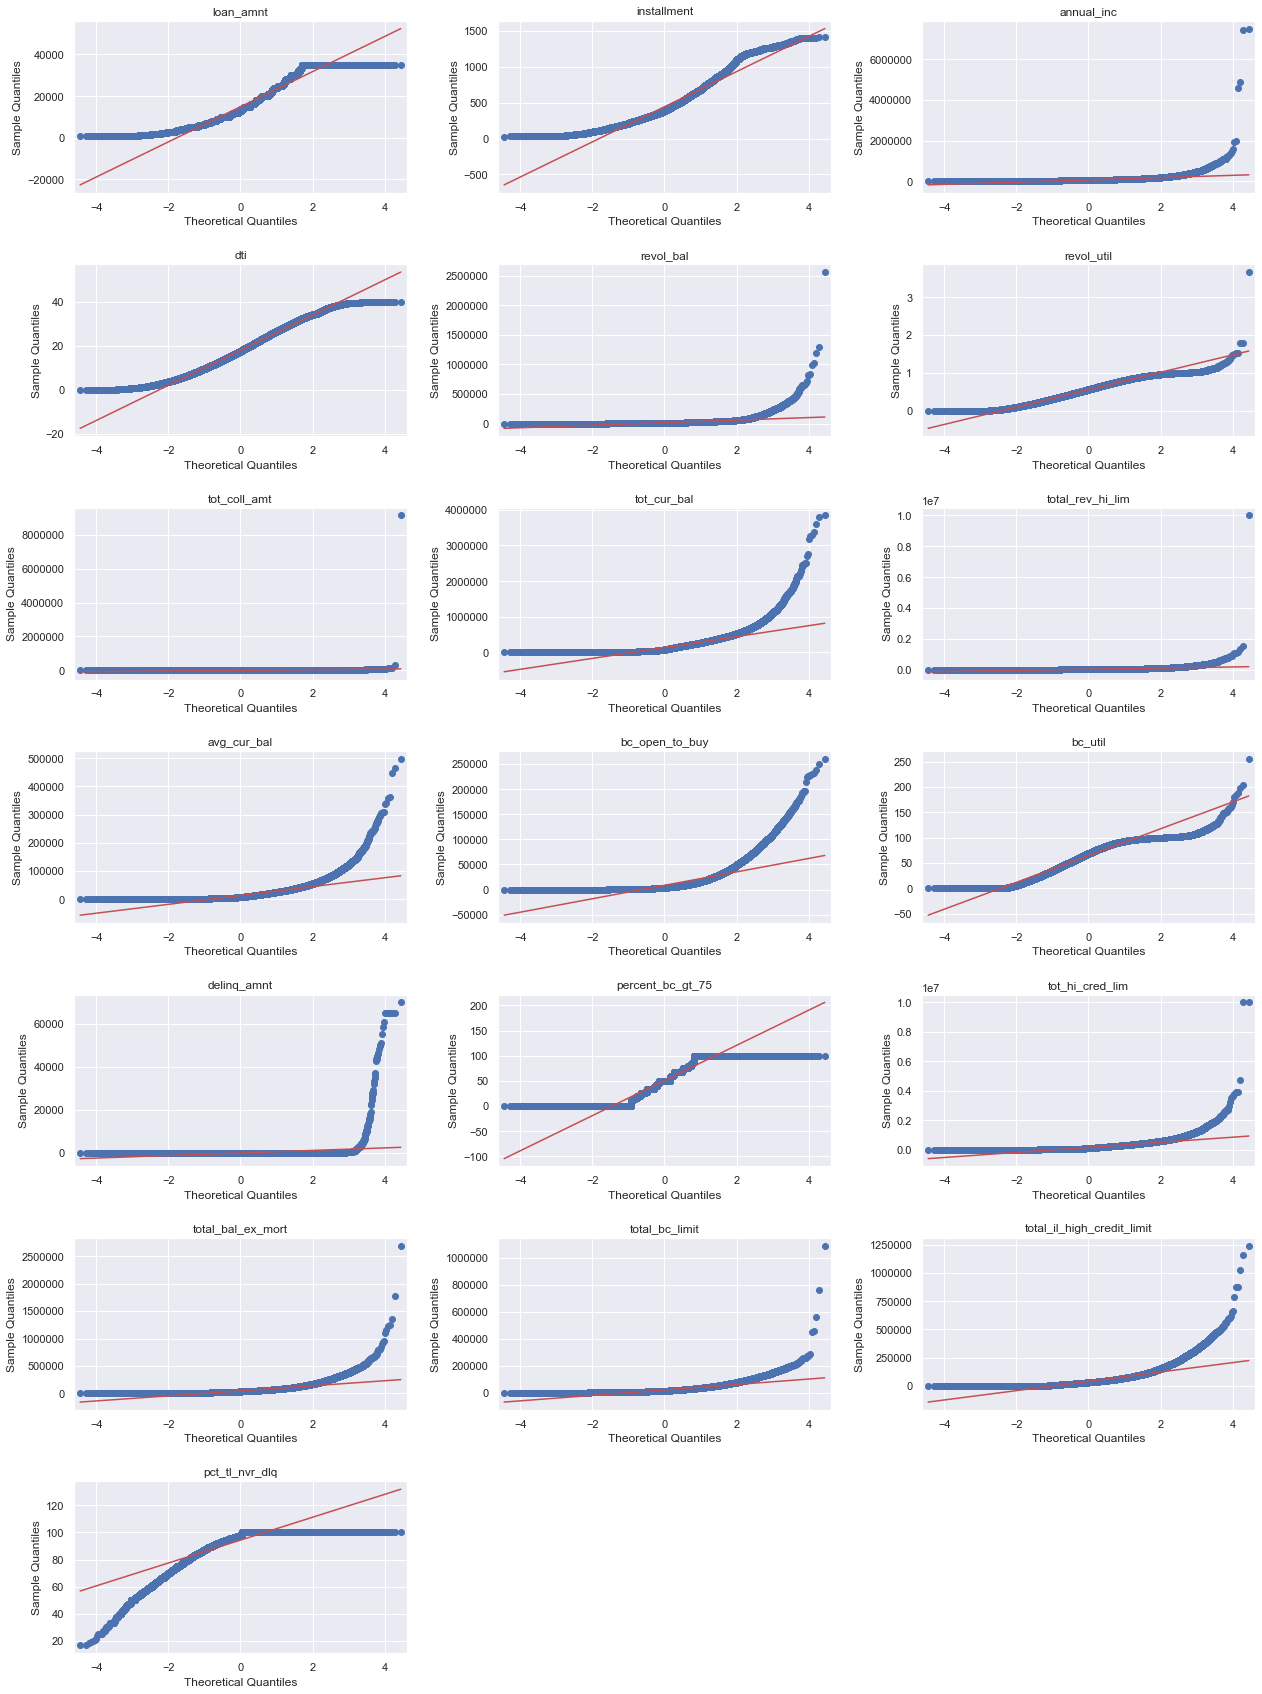

In [55]:
import statsmodels.api as sm
fig, axes = plt.subplots(7,3, figsize=(18,24))
ax = axes.flatten()
for i, feat in enumerate(continuous_vars):
    sm.qqplot(dataset[feat], line='s', ax=ax[i])
    ax[i].set_title(feat)
plt.subplot(7,3,20).set_visible(False)
plt.subplot(7,3,21).set_visible(False)
fig.tight_layout(pad=2.0)
fig.savefig('img/QQplot_cont_feats.png');
plt.show()

**Normality test with Saphiro-Wilk test**

The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution, named for Samuel Shapiro and Martin Wilk.

alpha = 0.01 significance level

In [56]:
from scipy.stats import shapiro

def feat_normality(data, alpha):
    stat, p = shapiro(data)
    print(f'{feat}: \tstatistics={stat:.3}, \tp={p:.5}.', end='\t')
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

for feat in continuous_vars:
    data = np.random.choice(dataset[feat], size=600, replace=False)
    feat_normality(data, 0.01)

loan_amnt: 	statistics=0.94, 	p=8.8411e-15.	Sample does not look Gaussian (reject H0)
installment: 	statistics=0.926, 	p=1.4044e-16.	Sample does not look Gaussian (reject H0)
annual_inc: 	statistics=0.628, 	p=5.0836e-34.	Sample does not look Gaussian (reject H0)
dti: 	statistics=0.985, 	p=8.8379e-06.	Sample does not look Gaussian (reject H0)
revol_bal: 	statistics=0.518, 	p=2.0238e-37.	Sample does not look Gaussian (reject H0)
revol_util: 	statistics=0.981, 	p=3.9214e-07.	Sample does not look Gaussian (reject H0)
tot_coll_amt: 	statistics=0.109, 	p=0.0.	Sample does not look Gaussian (reject H0)
tot_cur_bal: 	statistics=0.799, 	p=1.2794e-26.	Sample does not look Gaussian (reject H0)
total_rev_hi_lim: 	statistics=0.71, 	p=6.7911e-31.	Sample does not look Gaussian (reject H0)
avg_cur_bal: 	statistics=0.581, 	p=1.469e-35.	Sample does not look Gaussian (reject H0)
bc_open_to_buy: 	statistics=0.616, 	p=1.9546e-34.	Sample does not look Gaussian (reject H0)
bc_util: 	statistics=0.949, 	p=1.748

**Normality test after log transformation:**

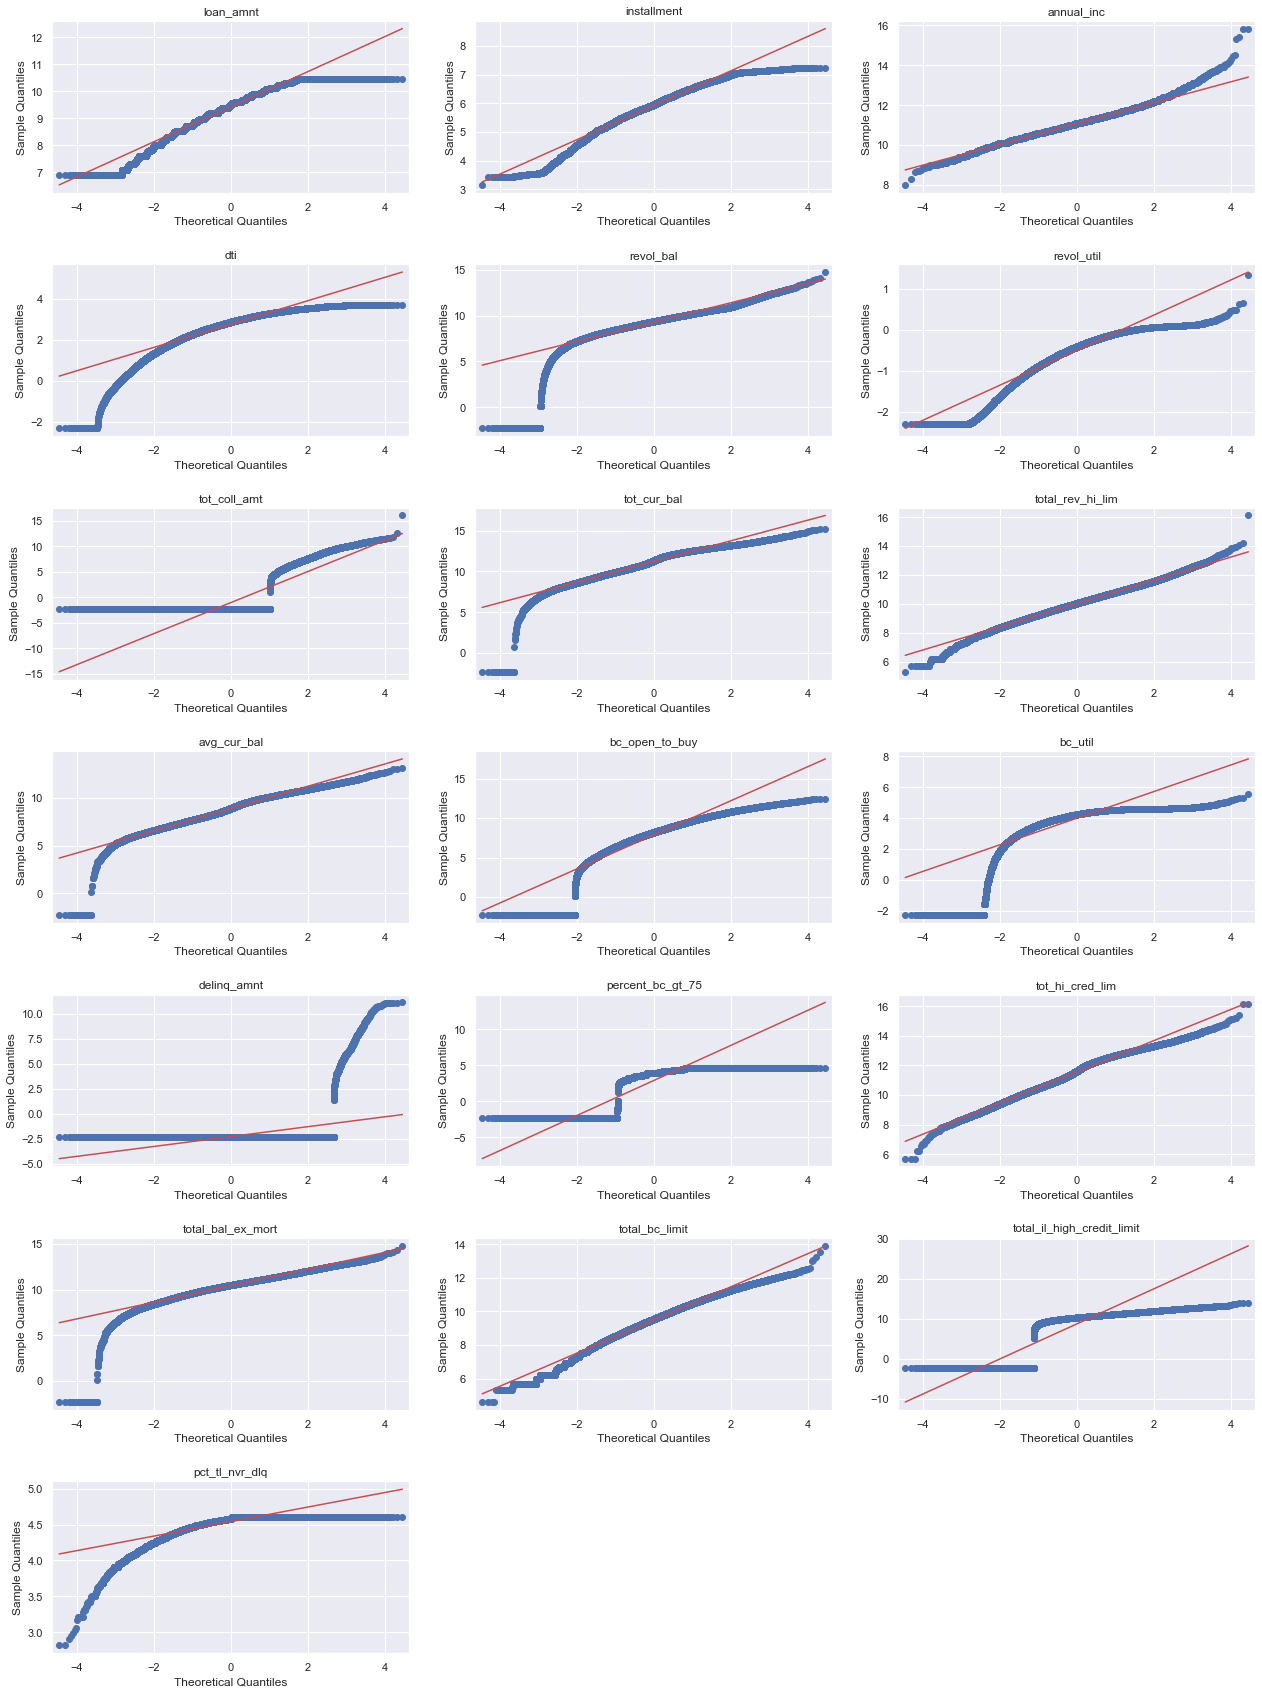

In [57]:
fig, axes = plt.subplots(7,3, figsize=(18,24))
ax = axes.flatten()
for i, feat in enumerate(continuous_vars): 
    data = dataset[feat].copy()
    if data.min() <= 0:
        data += 0.1 - dataset[feat].min()
    sm.qqplot(np.log(data), line='s', ax=ax[i])
    ax[i].set_title(feat)
plt.subplot(7,3,20).set_visible(False)
plt.subplot(7,3,21).set_visible(False)
fig.tight_layout(pad=2.0)
fig.savefig('img/QQplot_cont_logtrans.png');
plt.show()

In [58]:
for feat in continuous_vars:
    data = np.random.choice(dataset[feat], size=600, replace=False)
    if data.min() <= 0:
        data += 1 - dataset[feat].min()
    feat_normality(np.log(data), 0.01)

loan_amnt: 	statistics=0.974, 	p=6.5417e-09.	Sample does not look Gaussian (reject H0)
installment: 	statistics=0.98, 	p=3.1118e-07.	Sample does not look Gaussian (reject H0)
annual_inc: 	statistics=0.983, 	p=1.8886e-06.	Sample does not look Gaussian (reject H0)
dti: 	statistics=0.909, 	p=1.683e-18.	Sample does not look Gaussian (reject H0)
revol_bal: 	statistics=0.973, 	p=4.3447e-09.	Sample does not look Gaussian (reject H0)
revol_util: 	statistics=0.874, 	p=1.2925e-21.	Sample does not look Gaussian (reject H0)
tot_coll_amt: 	statistics=0.471, 	p=1.081e-38.	Sample does not look Gaussian (reject H0)
tot_cur_bal: 	statistics=0.968, 	p=3.2393e-10.	Sample does not look Gaussian (reject H0)
total_rev_hi_lim: 	statistics=0.988, 	p=6.3263e-05.	Sample does not look Gaussian (reject H0)
avg_cur_bal: 	statistics=0.984, 	p=4.0542e-06.	Sample does not look Gaussian (reject H0)
bc_open_to_buy: 	statistics=0.908, 	p=1.3983e-18.	Sample does not look Gaussian (reject H0)
bc_util: 	statistics=0.75, 	p

**Log transform of some varibales**

In [224]:
var_to_log = ['annual_inc', 'total_rev_hi_lim', 'total_bc_limit']

**Variables with excessive zero values** will be converted into binary values:

In [60]:
dataset['tot_coll_amt_bi'] = dataset.tot_coll_amt.apply(lambda x: 0 if x==0 else 1)
dataset.drop(columns='tot_coll_amt', inplace=True)

dataset['delinq_amnt_bi'] = dataset.delinq_amnt.apply(lambda x: 0 if x==0 else 1)
dataset.drop(columns='delinq_amnt', inplace=True)

**Categorical (ordinal) variable** from percent_bc_gt_75

In [61]:
from math import ceil
dataset['percent_bc_gt_75_cat'] = dataset.percent_bc_gt_75.apply(lambda x: ceil(x/10)/10)
dataset.drop(columns = 'percent_bc_gt_75', inplace=True)

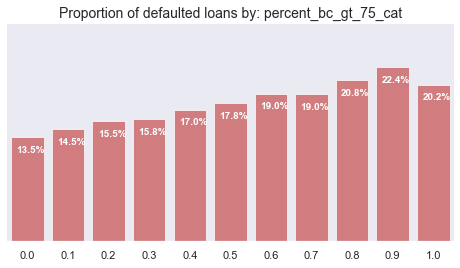

In [62]:
fig = plt.figure(figsize=(8,4))
ax = sns.barplot(sorted(dataset.percent_bc_gt_75_cat.unique()),
                 dataset.groupby('percent_bc_gt_75_cat').target.mean(),
                 color = '#db3b3b', alpha=0.7)

for p in ax.patches:
        ax.annotate('{:.1%}'.format(p.get_height()), (p.get_x()+0.13, p.get_height()-0.02), 
                    color='white', fontsize=10, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Proportion of defaulted loans by: percent_bc_gt_75_cat', fontsize=14)
plt.ylabel('')
plt.yticks([])
plt.ylim([0,0.28]);

### 6.2. Count variables

In [63]:
count_vars = ['mort_acc', 'mths_since_recent_inq', 'num_tl_120dpd_2m', 'tax_liens',  
              'num_tl_op_past_12m', 'grade', 'num_bc_tl', 'fico_range_low', 'open_acc', 'num_rev_accts', 
              'num_actv_rev_tl', 'inq_last_6mths', 'earliest_cr_line', 'delinq_2yrs', 'term', 'total_acc', 
              'emp_length', 'pub_rec', 'num_bc_sats', 'mo_sin_rcnt_tl', 'num_tl_90g_dpd_24m', 
              'num_actv_bc_tl', 'num_op_rev_tl', 'pub_rec_bankruptcies', 'mo_sin_rcnt_rev_tl_op', 
              'mths_since_recent_bc', 'num_tl_30dpd', 'num_sats', 'acc_open_past_24mths', 
              'num_accts_ever_120_pd', 'num_rev_tl_bal_gt_0', 'chargeoff_within_12_mths', 
              'mo_sin_old_il_acct', 'collections_12_mths_ex_med', 'num_il_tl', 'mo_sin_old_rev_tl_op']

print(f'There are {len(count_vars)} count (discrete) variables.')

There are 36 count (discrete) variables.


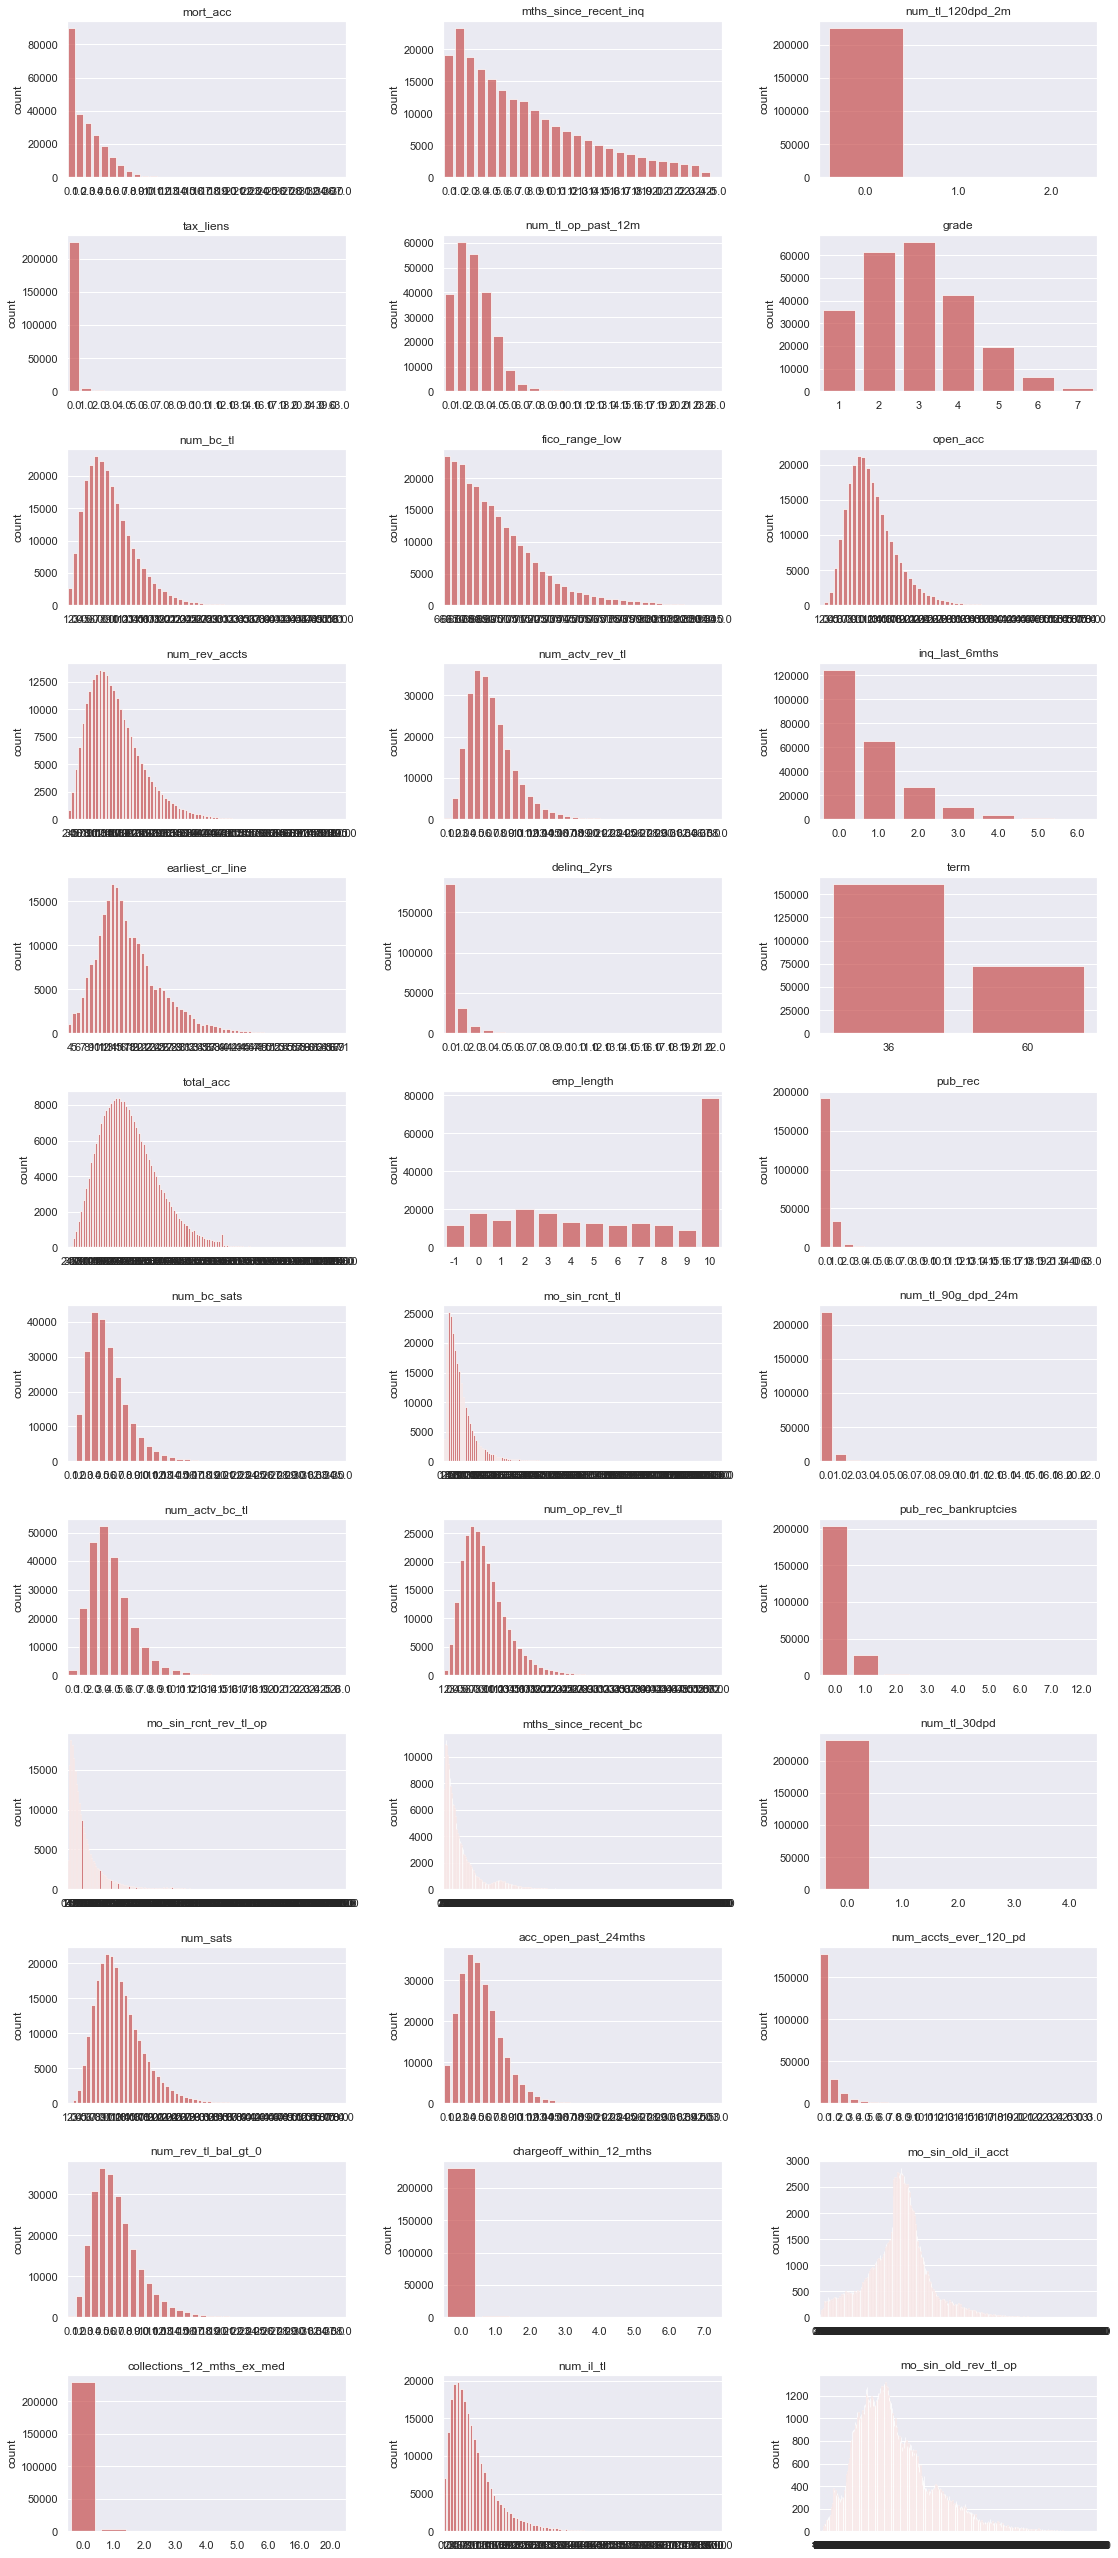

In [64]:
fig, axes = plt.subplots(12,3, figsize=(16,36))

for i, feat in enumerate(count_vars, start=1): 
    ax = plt.subplot(12,3,i)
    sns.countplot(x=feat, data=dataset, color='#db3b3b', alpha=0.7)
    ax.set_title(feat)
    ax.set_xlabel('')
# plt.subplot(12,3,36).set_visible(False)
fig.tight_layout(pad=2.0)
fig.savefig('img/Hist_count_feats.png');

In [115]:
dataset[dataset.num_tl_120dpd_2m==3].target.count()

0

**Normality check after log transform**

In [65]:
for feat in count_vars:
    data = np.random.choice(dataset[feat], size=600, replace=False)
    if data.min() <= 0:
        data += 1 - dataset[feat].min()
    feat_normality(np.log(data), 0.01)

mort_acc: 	statistics=0.877, 	p=2.2517e-21.	Sample does not look Gaussian (reject H0)
mths_since_recent_inq: 	statistics=nan, 	p=1.0.	Sample looks Gaussian (fail to reject H0)
num_tl_120dpd_2m: 	statistics=nan, 	p=1.0.	Sample looks Gaussian (fail to reject H0)
tax_liens: 	statistics=0.195, 	p=1.121e-44.	Sample does not look Gaussian (reject H0)
num_tl_op_past_12m: 	statistics=0.918, 	p=1.777e-17.	Sample does not look Gaussian (reject H0)
grade: 	statistics=0.901, 	p=2.7875e-19.	Sample does not look Gaussian (reject H0)
num_bc_tl: 	statistics=0.969, 	p=7.0954e-10.	Sample does not look Gaussian (reject H0)
fico_range_low: 	statistics=0.918, 	p=1.7809e-17.	Sample does not look Gaussian (reject H0)
open_acc: 	statistics=0.993, 	p=0.0088298.	Sample does not look Gaussian (reject H0)
num_rev_accts: 	statistics=0.982, 	p=7.4365e-07.	Sample does not look Gaussian (reject H0)
num_actv_rev_tl: 	statistics=0.979, 	p=1.1992e-07.	Sample does not look Gaussian (reject H0)
inq_last_6mths: 	statistics

**Logtransform of variables**

In [202]:
# var_to_log += ['mo_sin_old_il_acct', 'mo_sin_rcnt_rev_tl_op', 'mths_since_recent_bc', 'mths_since_recent_inq',
#               'num_rev_accts', 'open_acc']

**Variables with excessive zero values**

I handeled the zero values two different ways:
- creating binary features
- drop the features (where the associatian with target was not strong)

In [68]:
var_to_binary = {'delinq_2yrs':1, 'pub_rec_bankruptcies':1, 'num_accts_ever_120_pd':0,
                'collections_12_mths_ex_med':0}

for feat, tres in var_to_binary.items():
    feat_name = feat+'_bi'
    dataset[feat_name] = dataset[feat].apply(lambda x: 0 if x<=tres else 1)
    dataset.drop(columns=feat, inplace=True)

In [69]:
var_to_drop = ['tax_liens', 'pub_rec', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'chargeoff_within_12_mths',
               'num_tl_120dpd_2m']

for feat in var_to_drop:
    dataset.drop(columns=feat, inplace=True)

### 6.3. Handling outliers

**Find outliers using IQR method**

In [73]:
median = np.quantile(dataset.annual_inc, 0.5)
Q1 = np.quantile(dataset.annual_inc, 0.25)
Q3 = np.quantile(dataset.annual_inc, 0.75)
upper_tres1 = median + 1.5 * (Q3 - Q1)
print(f'Upper treshold: ${upper_tres1:,.0f}.')
print(f'There are {len(dataset[dataset.annual_inc > upper_tres1]):,} loans with income above this treshold.')

Upper treshold: $131,600.
There are 18,494 loans with income above this treshold.


**Find outliers using standard deviation method**

In [74]:
avg = dataset.annual_inc.mean()
std = np.std(dataset.annual_inc)
upper_tres2 = avg + 3 * std
print(f'Upper treshold: ${upper_tres2:,.0f}.')
print(f'There are {len(dataset[dataset.annual_inc >= upper_tres2]):,} loans with income above this treshold.')

Upper treshold: $241,156.
There are 2,651 loans with income above this treshold.


**Find outliers using 99 quantile**

In [75]:
upper_tres3 = np.quantile(dataset.annual_inc, 0.99)
print(f'Upper treshold: ${upper_tres3:,.0f}.')
print(f'There are {len(dataset[dataset.annual_inc >=upper_tres3]):,} loans with income above this treshold.')

Upper treshold: $250,000.
There are 2,529 loans with income above this treshold.


The last two solutions are close to each other, I will remove all datapoints with annual income $250,000 or higher.

In [77]:
indices = dataset[dataset.annual_inc < 250000].index
dataset = dataset.loc[indices]
print(f'The dataset contains {len(dataset):,} observations.')

The dataset contains 230,134 observations.


### 6.4. Pairwise correlation
By calculation Pearson correlation coefficient we can detect pairwise correlations between features.

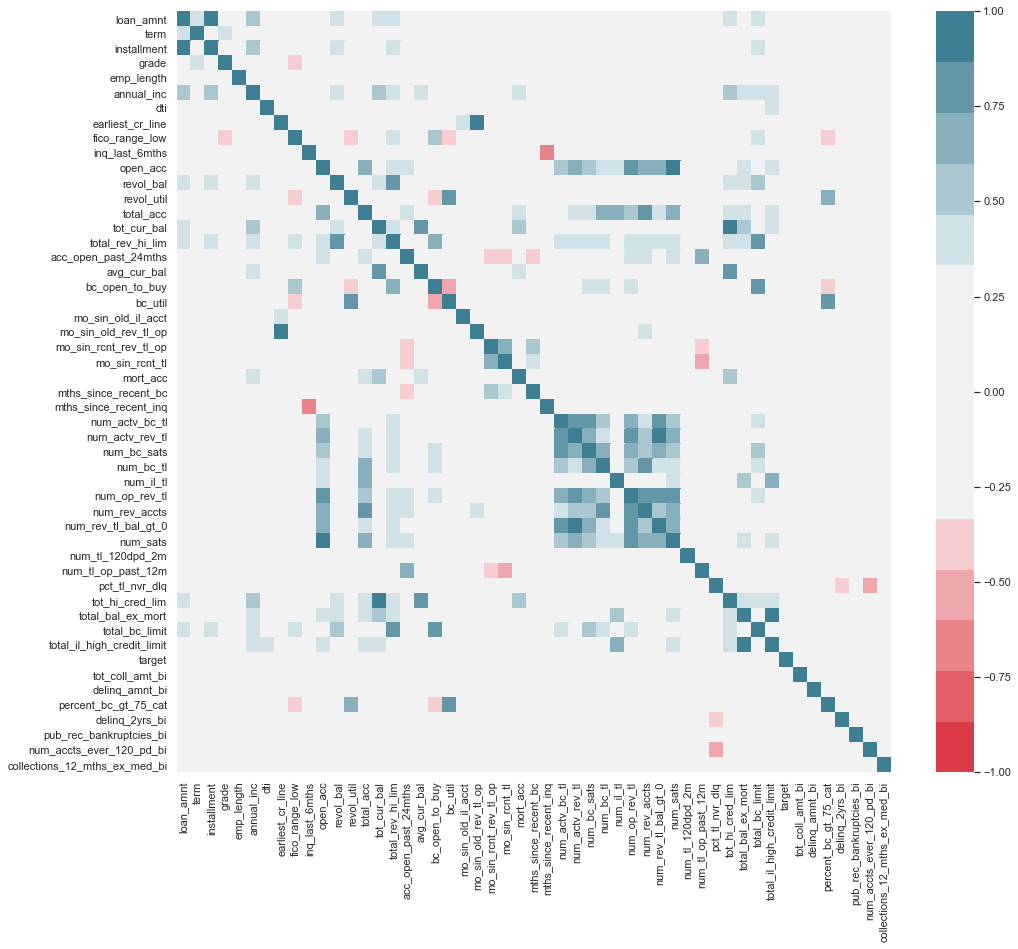

In [78]:
corr = dataset.corr()
plt.figure(figsize=(16,14))
sns.heatmap(corr, vmin=-1, vmax=1, cmap=sns.diverging_palette(10, 220, sep=80, n=15));

#### Scatterplot for the mostly correlated features

In [79]:
# the mostly correlated features
corr_list = []
for i in range(corr.shape[1]):
    for j in range(i+1, corr.shape[1]):
        if corr.iat[i,j]>0.9 or corr.iat[i,j]<-0.9:
            corr_list.append((corr.index[i], corr.columns[j], corr.iat[i,j]))
corr_df = pd.DataFrame(corr_list, columns = ['feat_1','feat_2', 'r_pearson'])                    
corr_df.sort_values(by='r_pearson', ascending=False)

,feat_1,feat_2,r_pearson
2,open_acc,num_sats,0.998644
4,num_actv_rev_tl,num_rev_tl_bal_gt_0,0.989414
3,tot_cur_bal,tot_hi_cred_lim,0.975385
0,loan_amnt,installment,0.947412
1,earliest_cr_line,mo_sin_old_rev_tl_op,0.923255


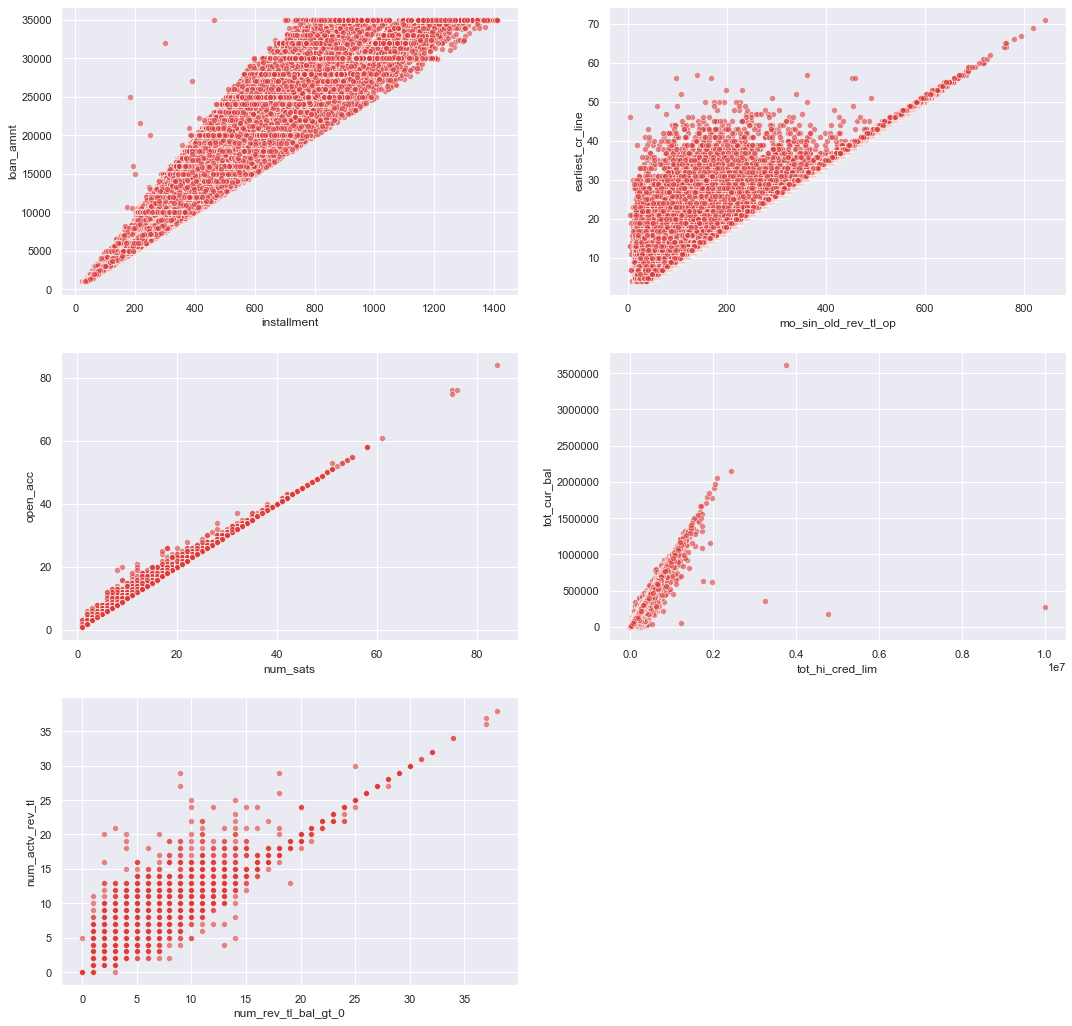

In [80]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18,18))

for i, corr_data in enumerate(corr_list, start=1):
    ax = plt.subplot(3,2,i)
    sns.scatterplot(corr_data[1], corr_data[0], data=dataset, alpha=0.6, color='#db3b3b')
    ax.set_xlabel(corr_data[1])
    ax.set_ylabel(corr_data[0])
plt.subplot(3,2,6).set_visible(False)

### 6.3. Multicollinearity - Variance Inflation Factor

By calculating Variance Inflation Factor we can find multicollinearity between certain featurs. Multicollinearity can be a problem in ordinary least squared analysis. A rule of thumb is that a feature with a VIF over 10 can be removed. As we will see, the multicollinearity is high, but if we not intend to use it for linear regression we can leave those features in our model.

In [81]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#these features object type or target variable:
cols_obj = ['home_ownership', 'verification_status', 'purpose', 'target', 'addr_state']
#these columns contain missing values
cols_mis = dataset.columns[dataset.isna().any()].tolist()

X = dataset.drop(columns = cols_obj + cols_mis, axis=1)
vif = [round(variance_inflation_factor(X.values, i),3) for i in range(X.shape[1])]

In [82]:
sorted(list(zip(X.columns, vif)), key=lambda x: x[1], reverse=True)[:26]

[('open_acc', 2602.231),
 ('num_sats', 2585.055),
 ('total_acc', 1921.339),
 ('num_rev_accts', 749.756),
 ('num_il_tl', 295.169),
 ('fico_range_low', 277.729),
 ('num_rev_tl_bal_gt_0', 277.34),
 ('num_actv_rev_tl', 261.464),
 ('loan_amnt', 226.781),
 ('pct_tl_nvr_dlq', 213.56),
 ('installment', 196.107),
 ('term', 113.785),
 ('tot_cur_bal', 69.276),
 ('num_op_rev_tl', 66.842),
 ('tot_hi_cred_lim', 66.564),
 ('earliest_cr_line', 46.399),
 ('total_rev_hi_lim', 44.081),
 ('total_bal_ex_mort', 43.073),
 ('bc_util', 42.225),
 ('mo_sin_old_rev_tl_op', 37.003),
 ('total_il_high_credit_limit', 34.218),
 ('num_actv_bc_tl', 32.656),
 ('num_bc_tl', 32.509),
 ('num_bc_sats', 30.471),
 ('revol_util', 30.099),
 ('revol_bal', 27.085)]

In [256]:
remove_due_coll = ['num_sats', 'total_acc','num_rev_tl_bal_gt_0']

X = dataset.drop(columns=cols_obj+remove_due_coll+cols_mis, axis=1)
vif = [round(variance_inflation_factor(X.values, i),3) for i in range(X.shape[1])]

KeyError: "['num_tl_120dpd_2m'] not found in axis"

In [91]:
sorted(list(zip(X.columns, vif)), key=lambda x: x[1], reverse=True)[:18]

[('fico_range_low', 245.502),
 ('pct_tl_nvr_dlq', 211.704),
 ('tot_cur_bal', 69.206),
 ('tot_hi_cred_lim', 66.439),
 ('num_op_rev_tl', 62.054),
 ('earliest_cr_line', 45.774),
 ('num_rev_accts', 45.063),
 ('total_rev_hi_lim', 43.564),
 ('num_sats', 42.724),
 ('total_bal_ex_mort', 42.443),
 ('bc_util', 42.179),
 ('mo_sin_old_rev_tl_op', 36.661),
 ('total_il_high_credit_limit', 33.614),
 ('num_bc_tl', 31.776),
 ('num_actv_bc_tl', 30.981),
 ('revol_util', 29.802),
 ('num_actv_rev_tl', 29.577),
 ('revol_bal', 26.761)]

### 6.4. Densityplot to visualize relationship between each numeric variables and target variable

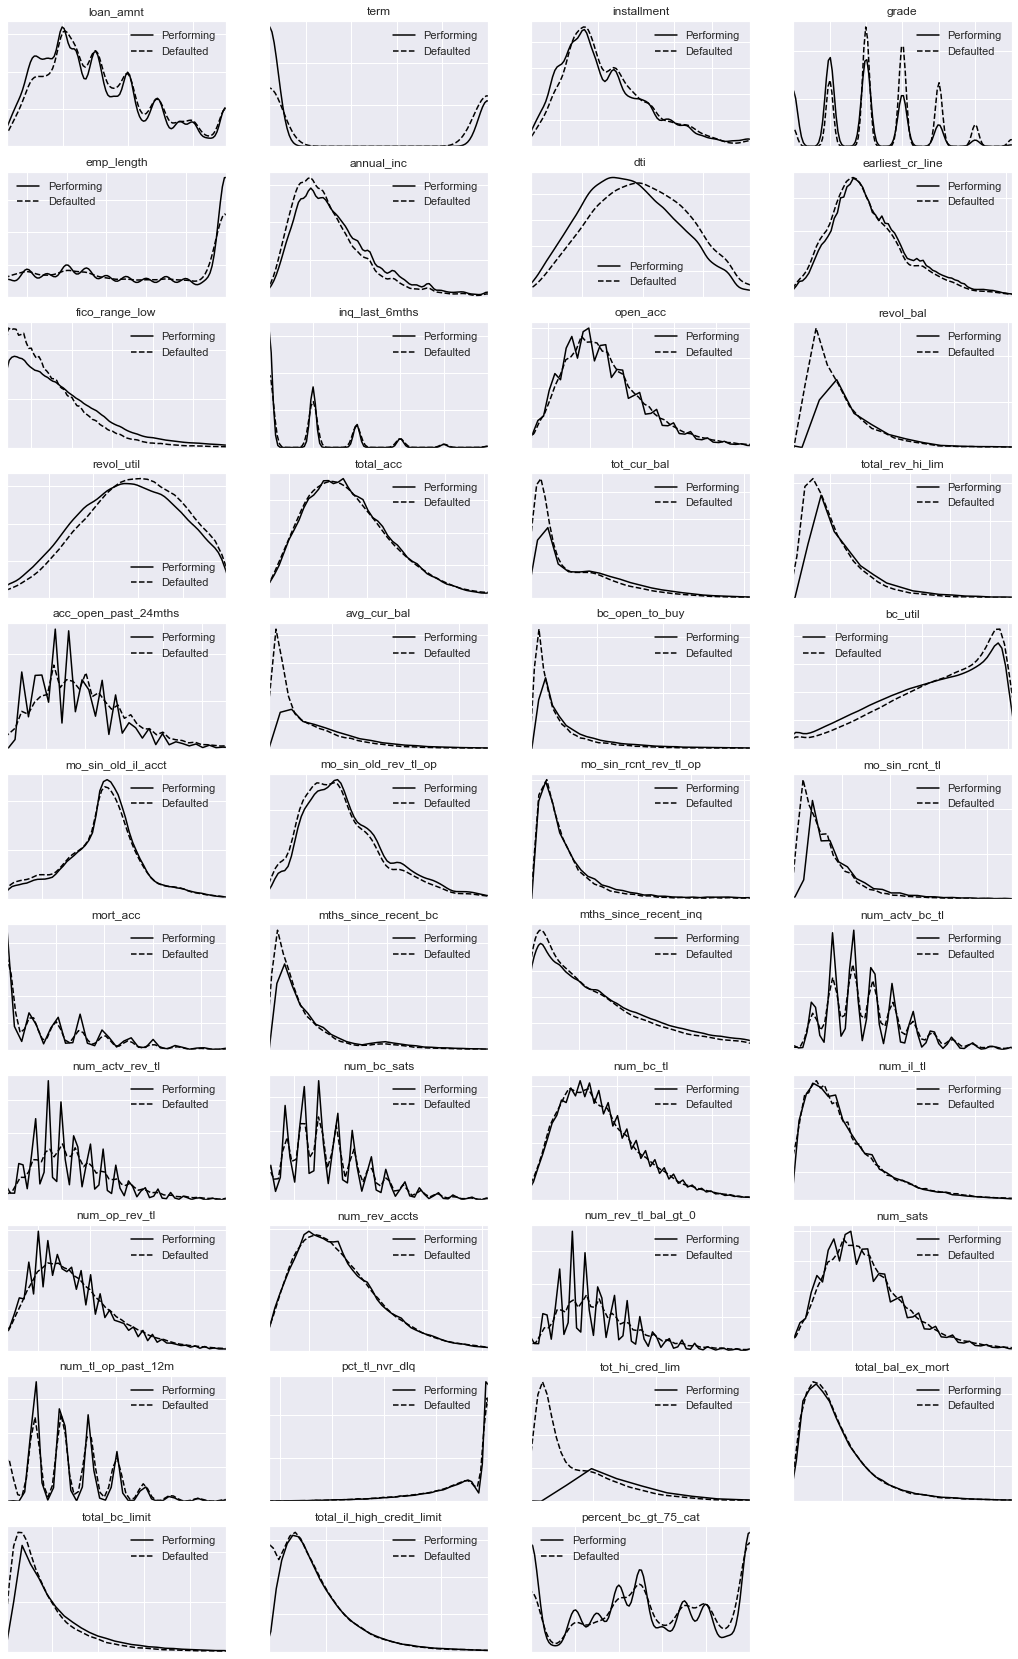

In [119]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(11,4, figsize=(18,30))

performing = dataset[dataset.target==0]
default = dataset[dataset.target==1]

num_feats = list(dataset.select_dtypes(['float64', 'int64']).columns[:-8]) + ['percent_bc_gt_75_cat']
#the last feat is the target we dont need
for i, feat in enumerate(num_feats, start=1): 
    ax = plt.subplot(11,4,i)
    try:
        sns.kdeplot(performing[feat], label='Performing', color='black', linestyle='-')
        sns.kdeplot(default[feat], label='Defaulted', color='black', linestyle='--')
    except:
        sns.kdeplot(performing[feat], label='Performing', color='black', linestyle='-', bw=0.5)
        sns.kdeplot(default[feat], label='Defaulted', color='black', linestyle='--', bw=0.5)
    ax.set_title(feat)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.legend(frameon=False)
    ax.set_xlim(right=max(np.nanpercentile(performing[feat],99), np.nanpercentile(default[feat],99)),
                left=min(np.nanpercentile(performing[feat],0.5), np.nanpercentile(default[feat],0.5)))
plt.subplot(11,4,44).set_visible(False)
fig.savefig('img/Densityplot.png');

There are only slight differences of density curve between performing and defaulted loans, which shows us the difficulty to predict target.

## 7. Preparing dataset for modeling

In [151]:
feats_dataset = dataset.drop(columns='target').columns
print('Number of features originally:', len(feats))

Number of features originally: 53


### 7.1. Creating dummy variables from qualitative (object type) features

In [152]:
X = pd.get_dummies(dataset[feats_dataset], drop_first=True).copy()
feats = X.columns
y = dataset.target.copy()
print(f'There are {X.shape[0]:,} observations and {X.shape[1]} features in the dataset.')

There are 230,134 observations and 110 features in the dataset.


In [154]:
feats[:50]

Index(['loan_amnt', 'term', 'installment', 'grade', 'emp_length', 'annual_inc',
       'dti', 'earliest_cr_line', 'fico_range_low', 'inq_last_6mths',
       'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'tot_cur_bal',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl',
       'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0',
       'num_sats', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
       'tot_coll_amt_bi', 'delinq_amnt_bi', 'percent_bc_gt_75_cat',
       'delinq_2yrs_bi', 'pub_rec_bankruptcies_bi', 'num_accts_ever_120_pd_bi',
       'collections_12_mths_ex_med_bi', 'home_ownership_OWN

In [155]:
print('Distribution of target variables:')
print(y.value_counts()/len(dataset))

Distribution of target variables:
0    0.822734
1    0.177266
Name: target, dtype: float64


In [66]:
# print('Features with dummies:')
# print(X.columns.to_list())

### 7.2. Train-Test Split

train : test = 80 : 20

In [225]:
#'Stratify=y' provide us the same ratio in the target variable then it was in the original dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y, test_size=0.2) 

print(f'Number of train set: {len(X_train):,}\nNumber of test set: {len(X_test):,}')

Number of train set: 184,107
Number of test set: 46,027


In [226]:
print('Test of the stratified split:')#This is a test to prove that the stratified split worked:
print('y_train:', y_train.mean())
print('y_test:', y_test.mean())

Test of the stratified split:
y_train: 0.1772664809051258
y_test: 0.1772655180654833


### 7.3. Handling Missing Values - separately for train and test

In [227]:
missing_cols = X_train.columns[X_train.isna().sum() > 0].tolist()
print('Columns with null values:\n', missing_cols)

Columns with null values:
 ['mo_sin_old_il_acct', 'mths_since_recent_inq']


In [228]:
X_train[missing_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
mo_sin_old_il_acct,178426.0,128.286842,51.228451,0.0,101.0,130.0,153.0,561.0
mths_since_recent_inq,167120.0,6.946392,5.932676,0.0,2.0,5.0,10.0,25.0


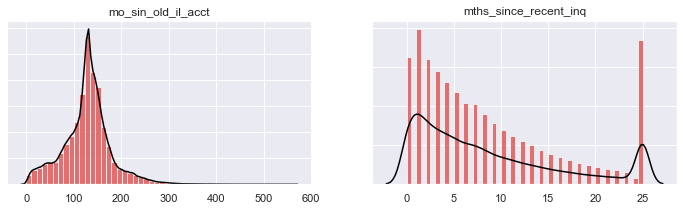

In [248]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(1,2, figsize=(12,3))

for i, feat in enumerate(missing_cols, start=1): 
    ax = plt.subplot(1,2,i)
    sns.distplot(X_train[feat].dropna(), hist=True, axlabel=False, kde_kws={'color':'black'},
                 hist_kws={'color':'#db3b3b', 'alpha':0.7})
    ax.set_title(feat)
    ax.set_yticklabels([]);

Inquiries are stored only for two years, that is why we can replace the missing values with 25.

In case of the other feature we will fill missing values with median.

In [230]:
# Fill nan with values:
X_train.mths_since_recent_inq.fillna(value=25, inplace=True)
X_test.mths_since_recent_inq.fillna(value=25, inplace=True)

X_train.mo_sin_old_il_acct.fillna(X_train.mo_sin_old_il_acct.median(), inplace=True)      
X_test.mo_sin_old_il_acct.fillna(X_test.mo_sin_old_il_acct.median(), inplace=True)      

In [231]:
print('Check the number of nan values:')
print('X_train:', X_train.isna().any().sum())
print('X_test:', X_test.isna().any().sum())

Check the number of nan values:
X_train: 0
X_test: 0


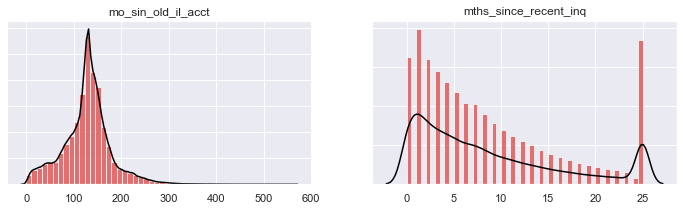

In [247]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(1,2, figsize=(12,3))

for i, feat in enumerate(missing_cols, start=1): 
    ax = plt.subplot(1,2,i)
    sns.distplot(X_train[feat].dropna(), hist=True, axlabel=False, kde_kws={'color':'black'},
                 hist_kws={'color':'#db3b3b', 'alpha':0.7})
    ax.set_title(feat)
    ax.set_yticklabels([]);

### 7.4. Log transformation

In [233]:
var_to_log

['annual_inc', 'total_rev_hi_lim', 'total_bc_limit']

In [241]:
X_train[var_to_log].min()

annual_inc          3000.0
total_rev_hi_lim    300.0 
total_bc_limit      100.0 
dtype: float64

In [242]:
def log_transform(data, var_to_log):
    for feat in var_to_log:
        var_name = feat + '_log'
        data[var_name] = np.log10(data[feat])
        data.drop(columns=feat, inplace=True)

In [243]:
log_transform(X_train, var_to_log)
log_transform(X_test, var_to_log)

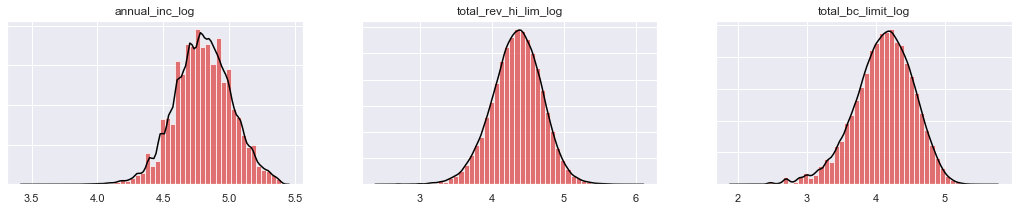

In [255]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(1,3, figsize=(18,3))

for i, feat in enumerate(var_to_log, start=1): 
    ax = plt.subplot(1,3,i)
    var_name = feat + '_log'
    sns.distplot(X_train[var_name], hist=True, axlabel=False, kde_kws={'color':'black'},
                 hist_kws={'color':'#db3b3b', 'alpha':0.7})
    ax.set_title(var_name)
    ax.set_yticklabels([]);

### 7.5. Scaling

The most standard scaling method

In [249]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 7.6. Save train/test sets for modeling purpuse

In [253]:
X_train.columns

Index(['loan_amnt', 'term', 'installment', 'grade', 'emp_length', 'dti',
       'earliest_cr_line', 'fico_range_low', 'inq_last_6mths', 'open_acc',
       ...
       'addr_state_UT', 'addr_state_VA', 'addr_state_VT', 'addr_state_WA',
       'addr_state_WI', 'addr_state_WV', 'addr_state_WY', 'annual_inc_log',
       'total_rev_hi_lim_log', 'total_bc_limit_log'],
      dtype='object', length=110)

In [250]:
pd.DataFrame(X_train_scaled).to_csv('preprocessing/X_train2.csv', header=None, index=None)
pd.DataFrame(X_test_scaled).to_csv('preprocessing/X_test2.csv', header=None, index=None)
pd.DataFrame(y_train).to_csv('preprocessing/y_train2.csv', header=None, index=None)
pd.DataFrame(y_test).to_csv('preprocessing/y_test2.csv', header=None, index=None)

In [254]:
pd.DataFrame(X_train.columns).to_csv('preprocessing/features.csv', header=None, index=None)